# Data Clustering - Bank Customer Segmentation Study

# Submitted by Charles Kilpatrick

## Problem Statement

Context
AllLife Bank plans to focus on its credit card customer base in the next financial year. They were advised by their marketing research team, that market penetration can be increased. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers and sell upscale products to existing customers. Another finding from the market research was that existing customers have a poor perception of the back office support services. Based on this, the Operations team plans to upgrade the service delivery model, to ensure customer queries are resolved faster and increase customer satisfaction. The Head of Marketing and the Head of Delivery both decide to reach out to the Data Science team for help.

The existing customer base is to be segmented to determine effective strategies for upselling existing customers and attracting new customers. Determining why customers perceive service poorly and determining ways to rectify this perception is also a key objective.**

Clustering algorithms will be the tool used to identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank and provide recommendations to the bank on how to better market to and service these customers.


## Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Importing Libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

# please uncomment and run the next line if yellowbrick library is not previously installed
# !pip install yellowbrick

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# !pip install tensorflow==2.9.1

import tensorflow as tf


## Use GPU If Available

In [2]:
#!pip install tensorflow

import tensorflow as tf

# Get the list of available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    # If a GPU is available, use it
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    device = "/GPU:0"
    print("Using GPU")
else:
    # If no GPU is available, use CPU
    device = "/CPU:0"
    print("Using CPU")

# Create a TensorFlow device context manager
# with tf.device(device):



Using GPU


### Loading Data

In [3]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_excel('/content/drive/MyDrive/Credit_Card_Customer_Data.xlsx')

In [5]:
# Loading the dataset - sheet_name parameter is used if there are multiple tabs in the excel file.
#data = pd.read_excel("Credit_Card_Customer_Data.xlsx")

### Data Overview

In [6]:
# Create a copy of the data
df = data.copy()

In [7]:
# Investigate dataframe shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")  # f-string

There are 660 rows and 7 columns.


* The dataset has 660 rows and 7 columns

In [8]:
# let's view the first 5 rows of the data
df.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

In [9]:
# Establish consistent random sampling
np.random.seed(1)
df.sample(10)

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
547    548         38125             26000                   4   
353    354         94437              9000                   5   
499    500         65825             68000                   6   
173    174         38410              9000                   2   
241    242         81878             10000                   4   
341    342         70779             18000                   4   
647    648         79953            183000                   9   
218    219         28208             19000                   3   
120    121         16577             10000                   4   
134    135         31256             13000                   4   

     Total_visits_bank  Total_visits_online  Total_calls_made  
547                  5                    2                 4  
353                  4                    1                 3  
499                  4                    2                 2  
173                  1                    5                 8  
241                  5                    1                 3  
341                  3                    2                 0  
647                  0                    9                 2  
218                  1                    5                 7  
120                  2                    4                 6  
134                  1                    5                 7

In [10]:
# let's view the last 5 rows of the data
df.tail()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
655    656         51108             99000                  10   
656    657         60732             84000                  10   
657    658         53834            145000                   8   
658    659         80655            172000                  10   
659    660         80150            167000                   9   

     Total_visits_bank  Total_visits_online  Total_calls_made  
655                  1                   10                 0  
656                  1                   13                 2  
657                  1                    9                 1  
658                  1                   15                 0  
659                  0                   12                 2

In [11]:
# let's check the data types of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


* All 7 columns are of int64 type.

In [12]:
# let's check for duplicate values in the data
df.duplicated().sum()

0

* There are no duplicated values

In [13]:
# let's check for missing values in the data
round(df.isnull().sum() / df.isnull().count() * 100, 2)

Sl_No                  0.0
Customer Key           0.0
Avg_Credit_Limit       0.0
Total_Credit_Cards     0.0
Total_visits_bank      0.0
Total_visits_online    0.0
Total_calls_made       0.0
dtype: float64

* There are no null values

In [14]:
# let's view the statistical summary of the numerical columns in the data
df.describe().T

count          mean           std      min       25%  \
Sl_No                660.0    330.500000    190.669872      1.0    165.75   
Customer Key         660.0  55141.443939  25627.772200  11265.0  33825.25   
Avg_Credit_Limit     660.0  34574.242424  37625.487804   3000.0  10000.00   
Total_Credit_Cards   660.0      4.706061      2.167835      1.0      3.00   
Total_visits_bank    660.0      2.403030      1.631813      0.0      1.00   
Total_visits_online  660.0      2.606061      2.935724      0.0      1.00   
Total_calls_made     660.0      3.583333      2.865317      0.0      1.00   

                         50%       75%       max  
Sl_No                  330.5    495.25     660.0  
Customer Key         53874.5  77202.50   99843.0  
Avg_Credit_Limit     18000.0  48000.00  200000.0  
Total_Credit_Cards       5.0      6.00      10.0  
Total_visits_bank        2.0      4.00       5.0  
Total_visits_online      2.0      4.00      15.0  
Total_calls_made         3.0      5.00      10.0

#### Observations:
* Sl_No: This is basically the row number for the dataset incrementing in units of one from 1 to 660.
* Customer Key: This is the customer identification number and is not of significance for this study.
* Average Credit Limit: The mean average credit limit for all cards, 34574.2 is much greater than the median value of 18000.0,   which * suggests this data is right skewed.  The minimum value is 3000.0 and the maximum value is 200000.0 .
* Total credit cards: The median total number of credit cards is 5.0 which is close to the mean number of credit cards which is  4.7. The minimum number of credit cards is 1.0 and the maximum number is 10.0 .
* Total visits bank: The median value of 2.0 is less than the mean value of 2.4 suggesting that the data is right skewed. The   * minimum total visits bank is 0.0 and the maximum total visits bank is 5.0.
* Total visits online: The mean value of total visits online, 2.6 is greater than the median value of total visits online, 2.0, which suggests that the data is right skewed. The minimum number of total visits online is 0.0 and the maximum number of total visits online is 15.0.
* Total calls made: The mean number of total calls made, 3.6 is greater than the median total calls made, suggesting that the data is right skewed. The minimum total calls made is 0.0 and the maximum total calls made is 10.0.

In [15]:
for i in df.describe(include=["int64"]).columns:
    print("Unique values in", i, "are :")
    print(df[i].value_counts())
    print("*" * 50)

Unique values in Sl_No are :
1      1
435    1
437    1
438    1
439    1
      ..
221    1
222    1
223    1
224    1
660    1
Name: Sl_No, Length: 660, dtype: int64
**************************************************
Unique values in Customer Key are :
97935    2
50706    2
47437    2
37252    2
96929    2
        ..
73811    1
72892    1
51773    1
96163    1
80150    1
Name: Customer Key, Length: 655, dtype: int64
**************************************************
Unique values in Avg_Credit_Limit are :
8000      35
6000      31
9000      28
13000     28
19000     26
10000     26
11000     24
7000      24
14000     23
18000     23
17000     23
16000     22
5000      21
20000     20
12000     18
15000     17
36000     11
70000     10
50000      8
38000      8
68000      7
39000      7
56000      7
41000      6
47000      6
52000      6
48000      6
74000      6
37000      6
30000      6
34000      6
65000      5
26000      5
29000      5
31000      5
60000      5
69000      4
51000  

### Observations
* There are five cases where the customer key is duplicated.  This will need to be investigated.

In [16]:
df[df["Customer Key"] == 97935]

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
104    105         97935             17000                   2   
632    633         97935            187000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
104                  1                    2                10  
632                  1                    7                 0

In [17]:
df[df["Customer Key"] == 50706]

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
411    412         50706             44000                   4   
541    542         50706             60000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
411                  5                    0                 2  
541                  5                    2                 2

In [18]:
df[df["Customer Key"] == 47437]

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
4        5         47437            100000                   6   
332    333         47437             17000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
4                    0                   12                 3  
332                  3                    1                 0

In [19]:
df[df["Customer Key"] == 37252]

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
48      49         37252              6000                   4   
432    433         37252             59000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
48                   0                    2                 8  
432                  2                    1                 2

In [20]:
df[df["Customer Key"] == 96929]

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
391    392         96929             13000                   4   
398    399         96929             67000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
391                  5                    0                 0  
398                  2                    2                 2

### Observations
* None of the non unique Customer Key entries are duplicates. None of the entries need to be deleted.

## Data Cleaning and Pre-processing

In [21]:
# SI_No consists of the primary key of the records and hence will not add value to the modeling.  Drop this parameter
df.drop(["Sl_No"], axis=1, inplace=True)

<Axes: xlabel='Customer Key', ylabel='Count'>

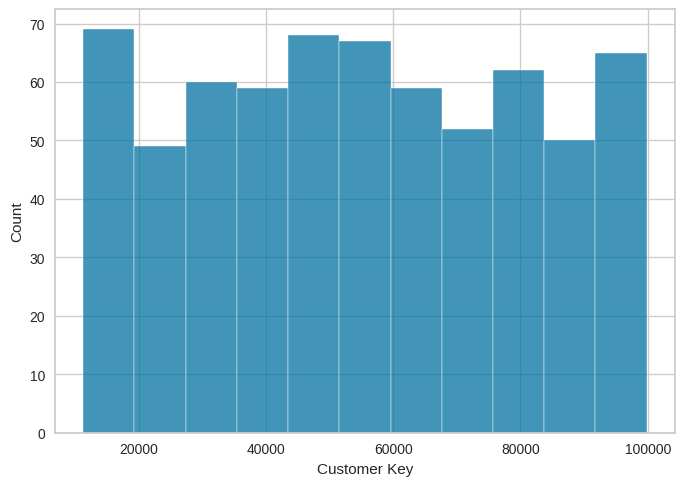

In [22]:
sns.histplot(data=df, x="Customer Key")

As shown by this histogram Customer Key will not add value for clustering the data.  This feature will be deleted.

In [23]:
# Delete Customer Key. This consists of the primary key of the records and does not add value to the modeling
df.drop(["Customer Key"], axis=1, inplace=True)


### EDA Section

#### The below functions need to be defined to carry out the Exploratory Data Analysis.

In [24]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [25]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [26]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [27]:
### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()


###  Univariate Analysis



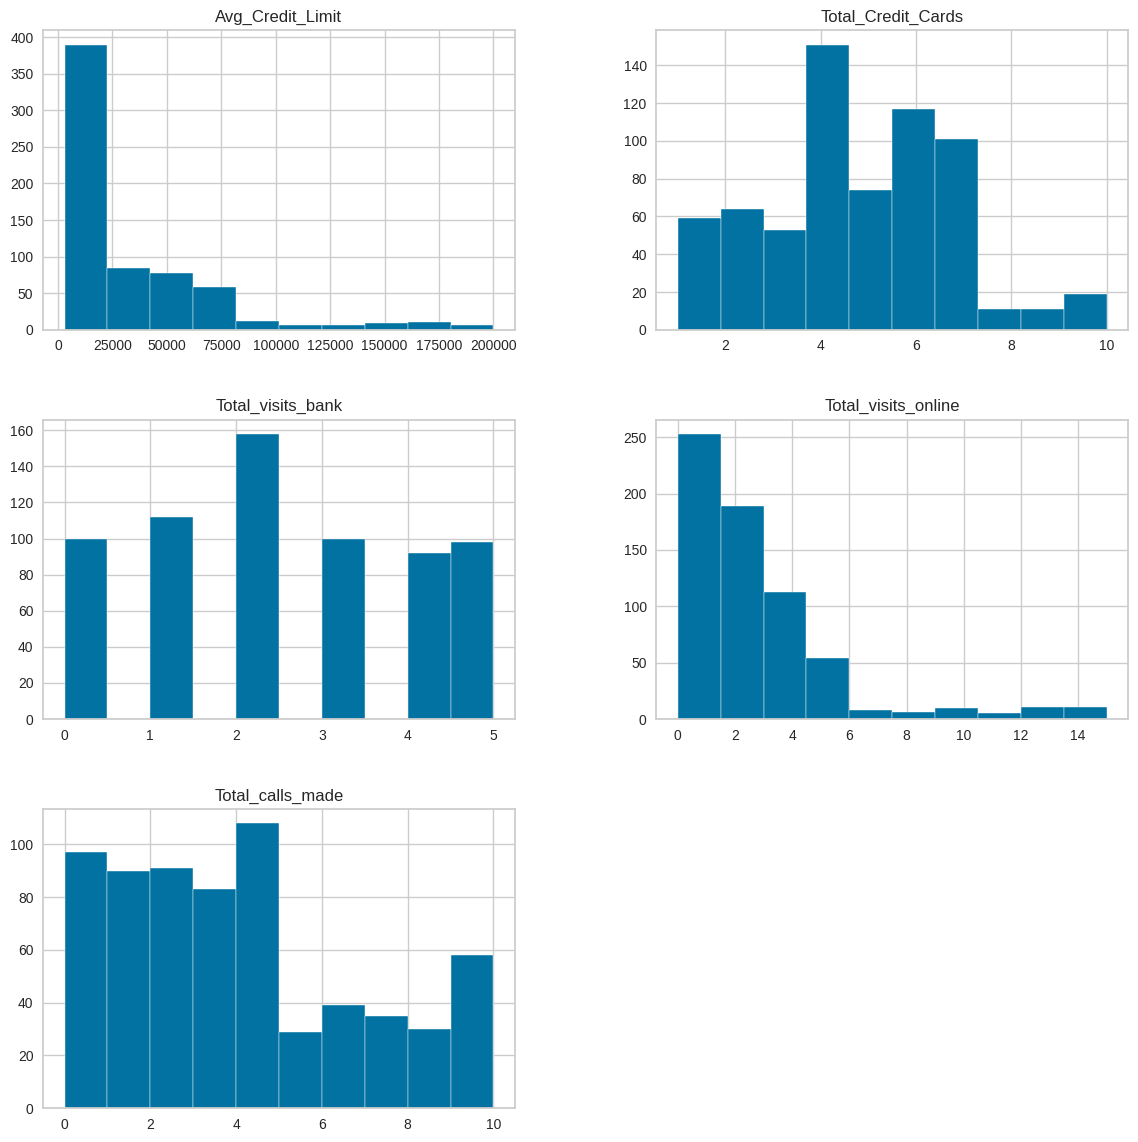

In [28]:
# creating histograms
df.hist(figsize=(14, 14))
plt.show()


### Summary of Histograms

* Avg_Credit_Limit:  The modal of the customers credit limit is less than 25000. The data is right skewed as there are relatively small numbers of customers with very high credit limits.  This is believed to be valid data.
* Total_Credit_Cards: The modal value is 4. A relatively small number of customers have between 8 and 10 credit cards.  All of the data appears to be valid.
* Total_visits_bank:  This data is normally distributed with a mean of approximately 2 visits per customer.
* Total_visits_online: This data is right skewed with a minimum value of 0 and a maximum value of 15.
* Total_calls_made:  This data is right skewed with lower numbers of customers making 5 or more calls.



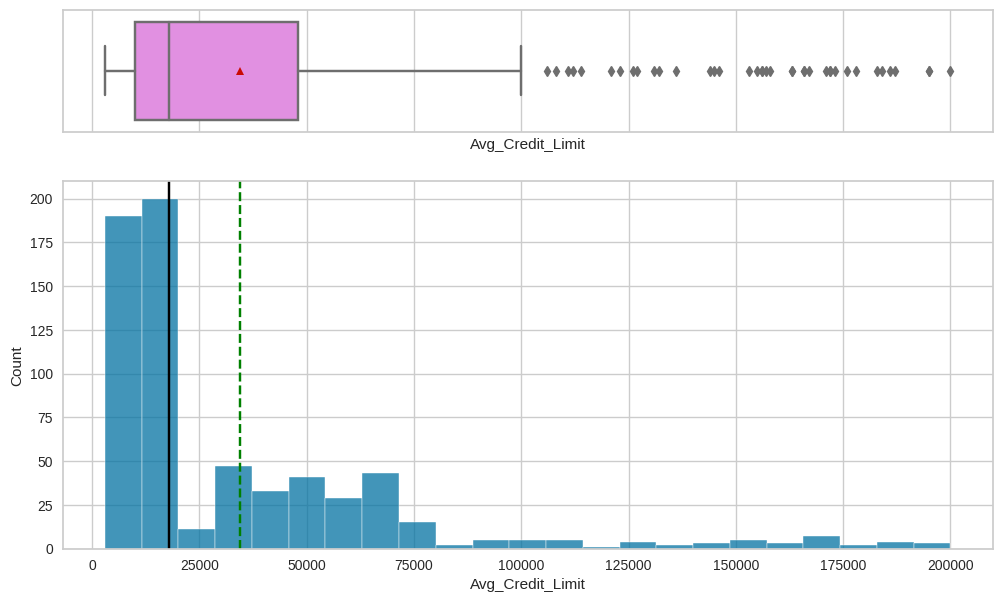

In [29]:
histogram_boxplot(df, "Avg_Credit_Limit")

The mean value of Avg_Credit_Limit 34574 is greater than the median value of 18000, thus the data is right skewed. There are a number of high outlier values greater than the right whisker value of 105000. These high outliers appear to be valid data and no preprocessing other than scaling will be applied to this data.

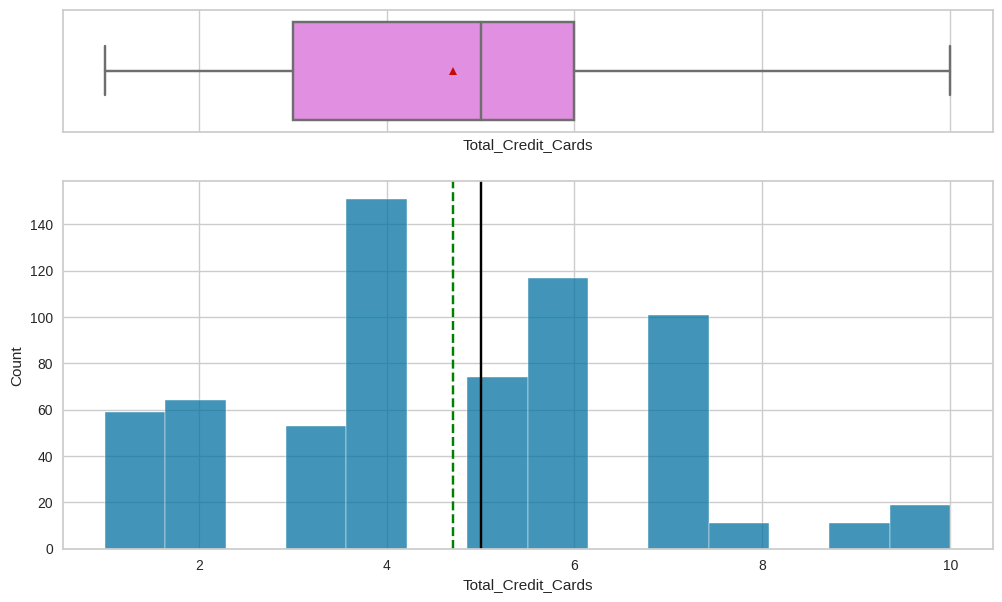

In [30]:
histogram_boxplot(df, "Total_Credit_Cards")

The Total_Credit_Cards data is distributed relatively normally with mean of 4.71 and median of 5.00.  There are no outliers and no further preprocessing will be applied other than scaling.  

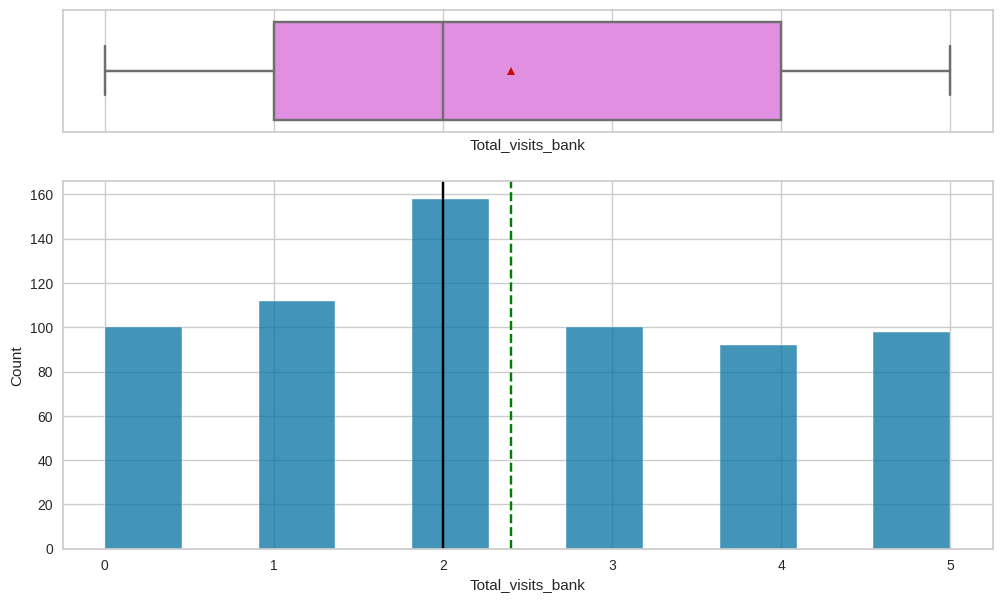

In [31]:
histogram_boxplot(df, "Total_visits_bank")

The Total_visits_bank data is right skewed as the mean value of 2.4 is greater than 2.0.  There are no outliers and no further treatment is required other than scaling.

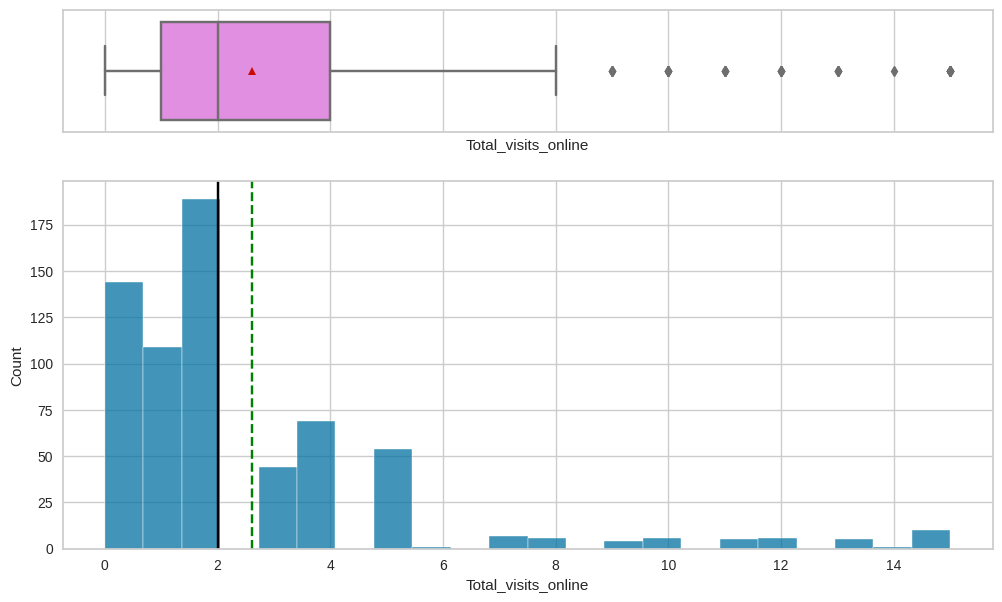

In [32]:
histogram_boxplot(df, "Total_visits_online")

The Total_visits_online data is righted skewed with the mean value of 2.61 greater than the median value of 2.00. There are a number of high outliers greater than the right whisker value of 8.5.  There is no basis to deem this data suspect and no further treatment other than scaling is required.

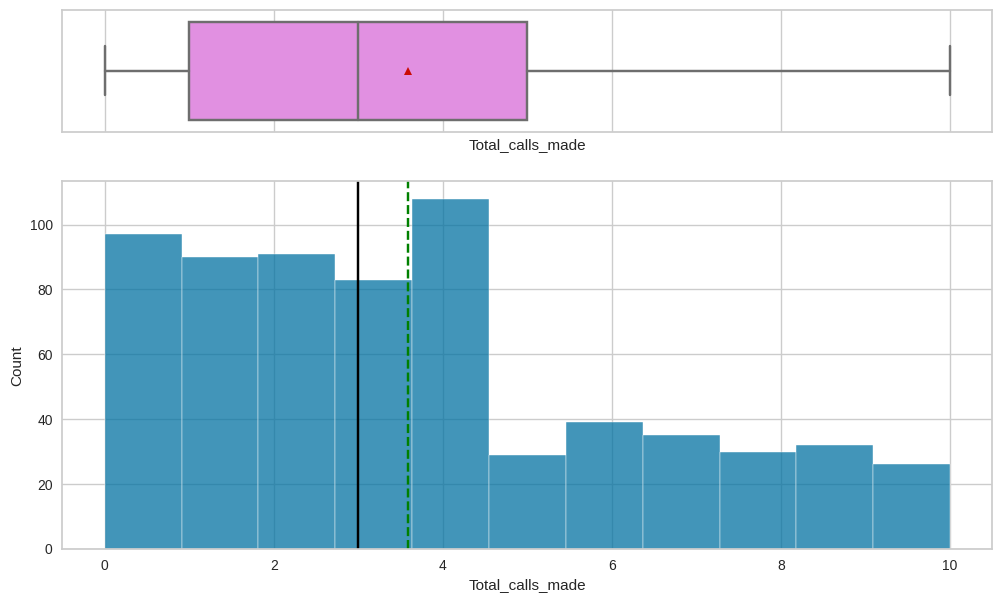

In [33]:
histogram_boxplot(df, "Total_calls_made")

The Total_calls_made data is right skewed with the mean of 3.58 being greater than the median value of 3.00. The are no outliers and no further treatment other than scaling is required.

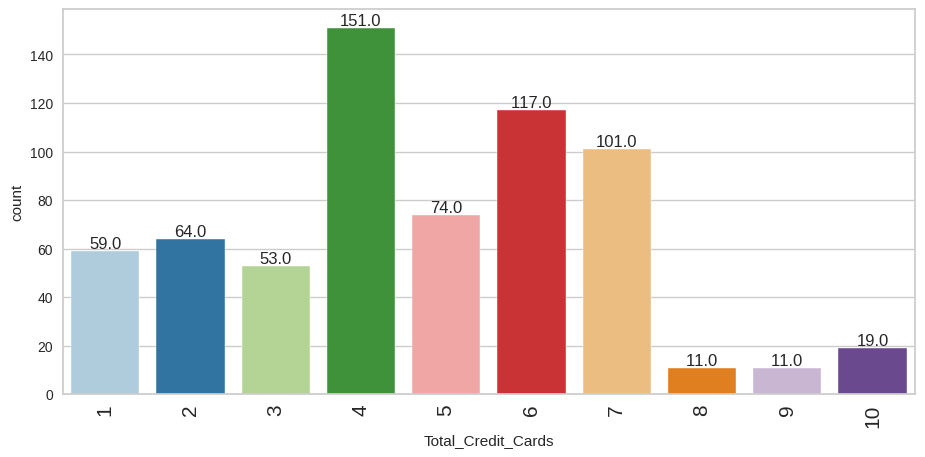

In [34]:
labeled_barplot(df, "Total_Credit_Cards")

The modal value for Total__Credit_Cards is 4 with a normal distribution and mean of 5.0.

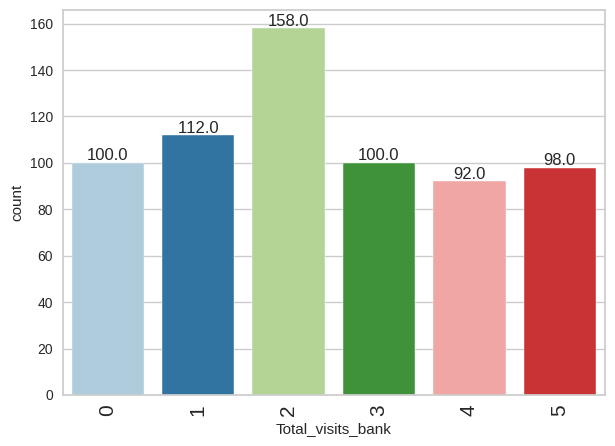

In [35]:
labeled_barplot(df, "Total_visits_bank")

The Total_visits_bank is modal value is 2 and the data is right skewed.

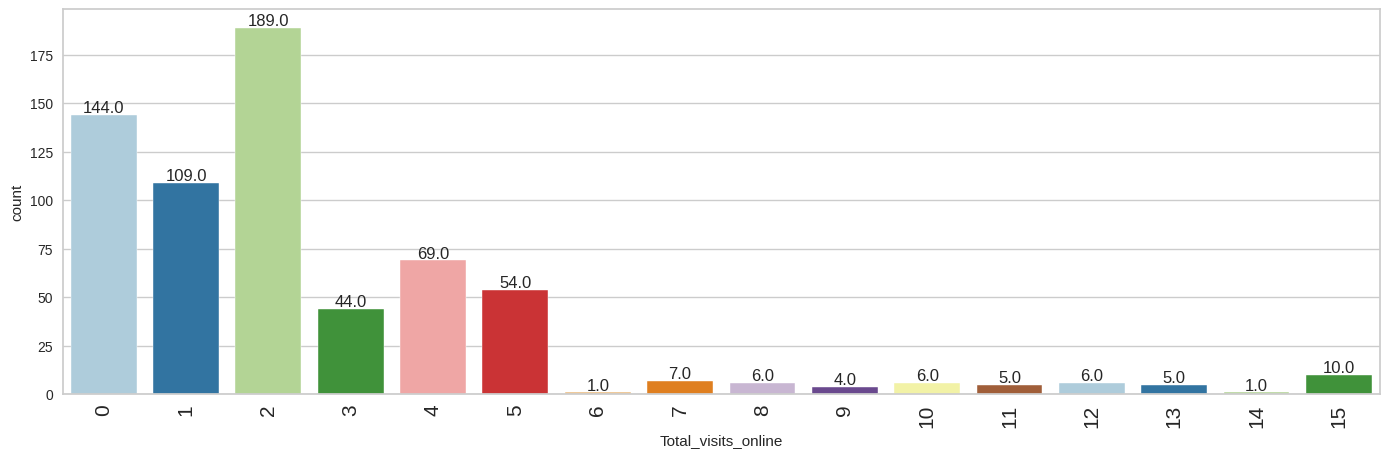

In [36]:
labeled_barplot(df, "Total_visits_online")

The Total_visits_online modal value is 2 and the data is right skewed.

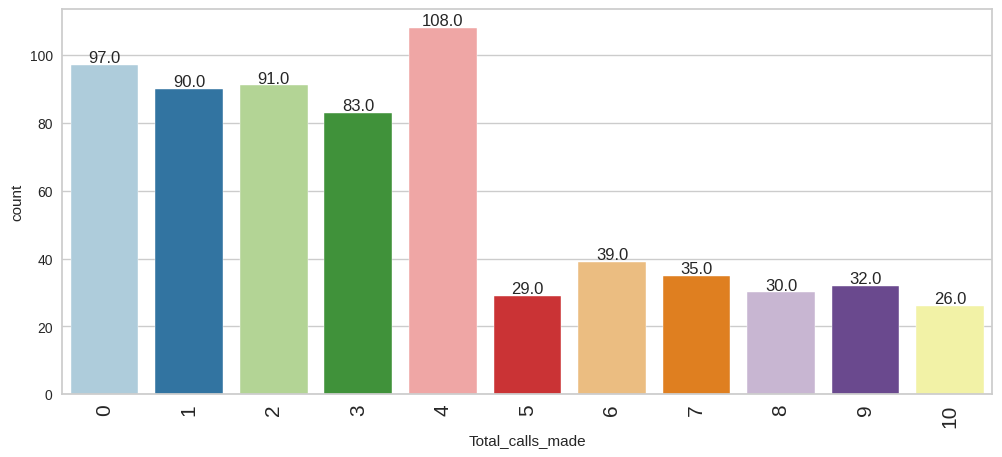

In [37]:
labeled_barplot(df, "Total_calls_made")

The Total_calls_made modal value is 4 and the data is right skewed.

###  Multivariate Analysis

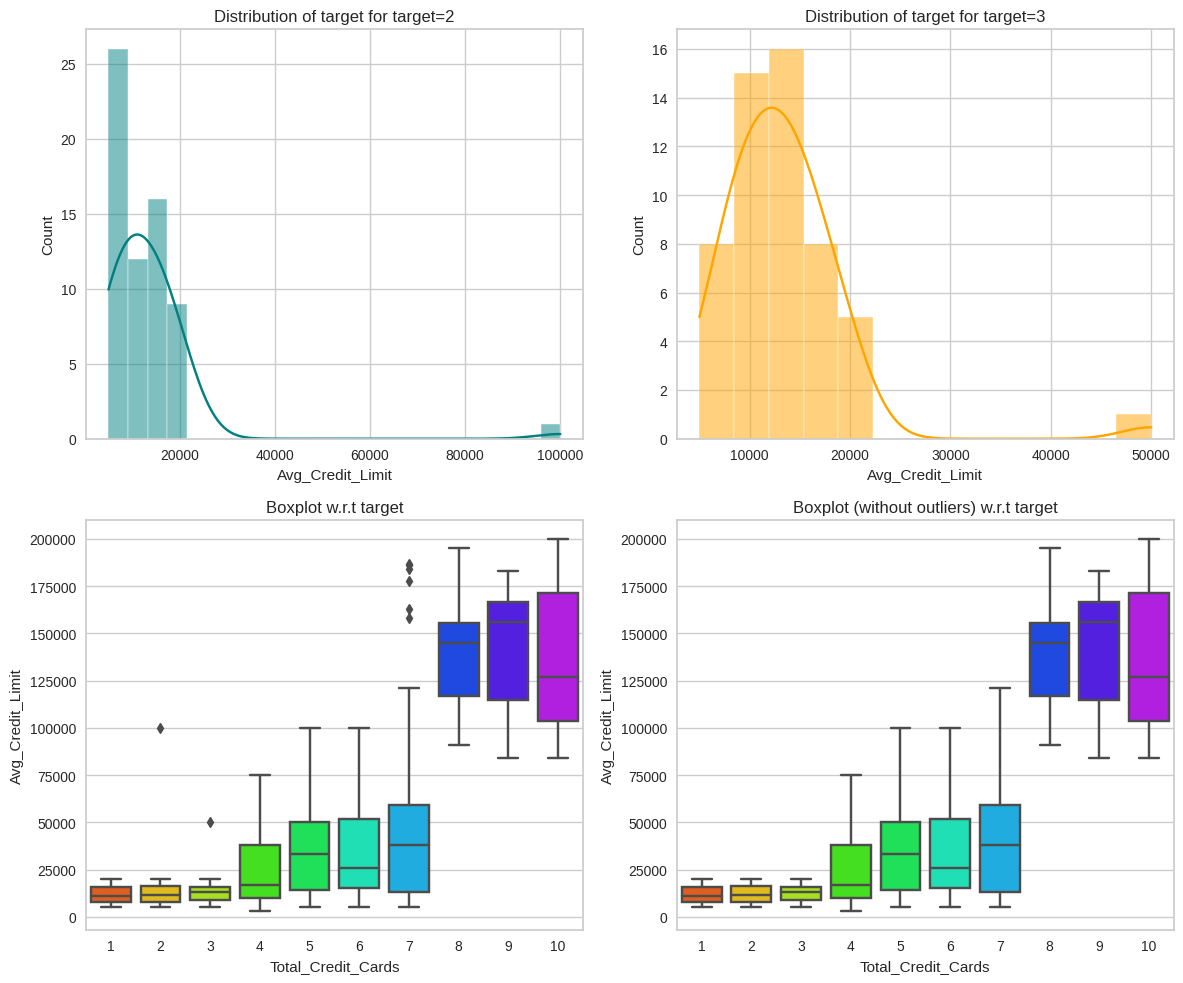

In [38]:
distribution_plot_wrt_target(df, "Avg_Credit_Limit", "Total_Credit_Cards")

There is a clear trend of increasing credit limit with increasing number of credit cards. This is true whether or not the high outliers for Total_Credit_Cards are included.

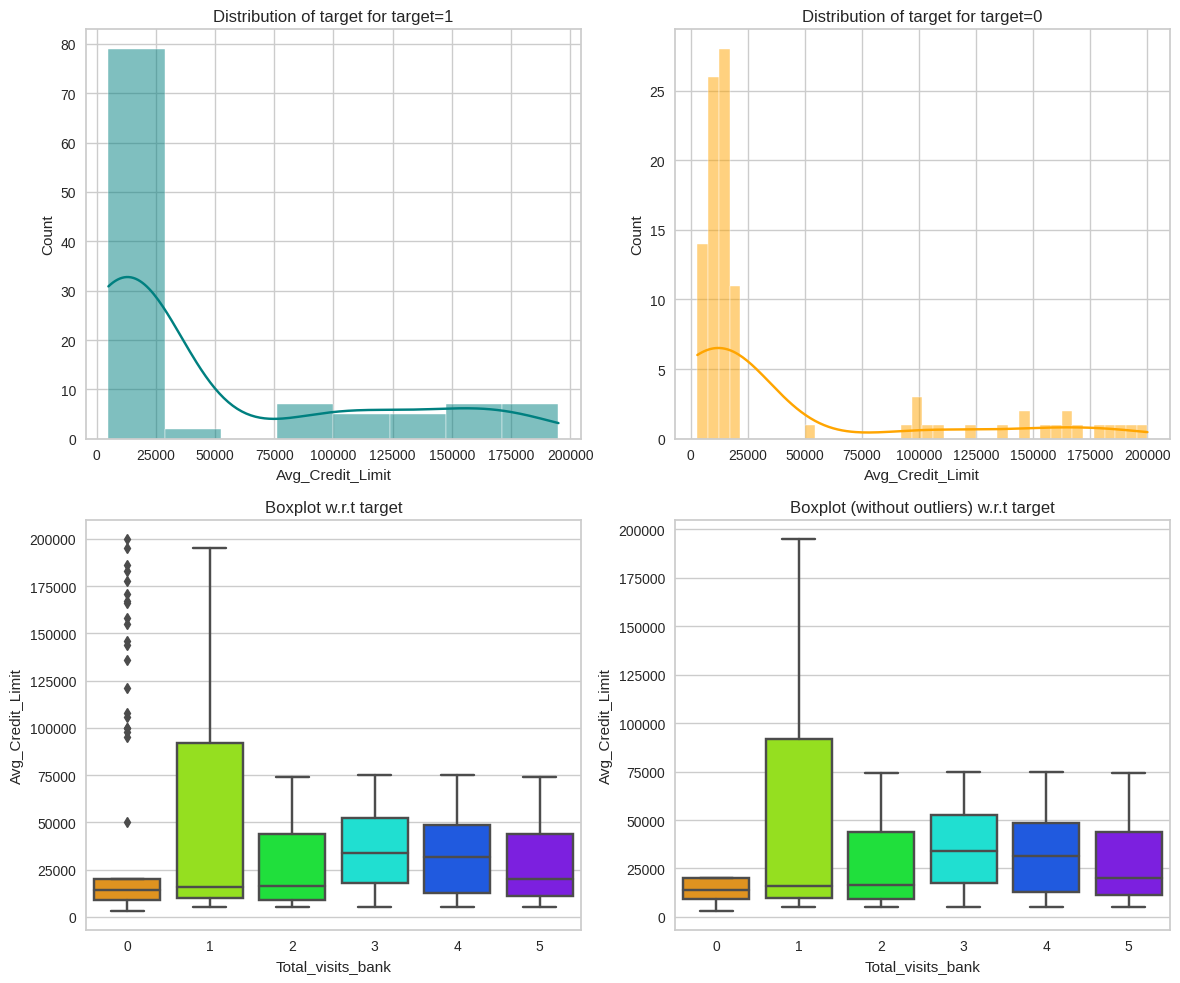

In [39]:
distribution_plot_wrt_target(df, "Avg_Credit_Limit", "Total_visits_bank")

There is a lesser number of customers with 0 bank visits.  There are also Avg_Credit_Limit outliers who have 0 bank visits. The most frequent number of bank visits is 1.  Approximately equal number of customers have 2,3, 4, or 5 bank visits.

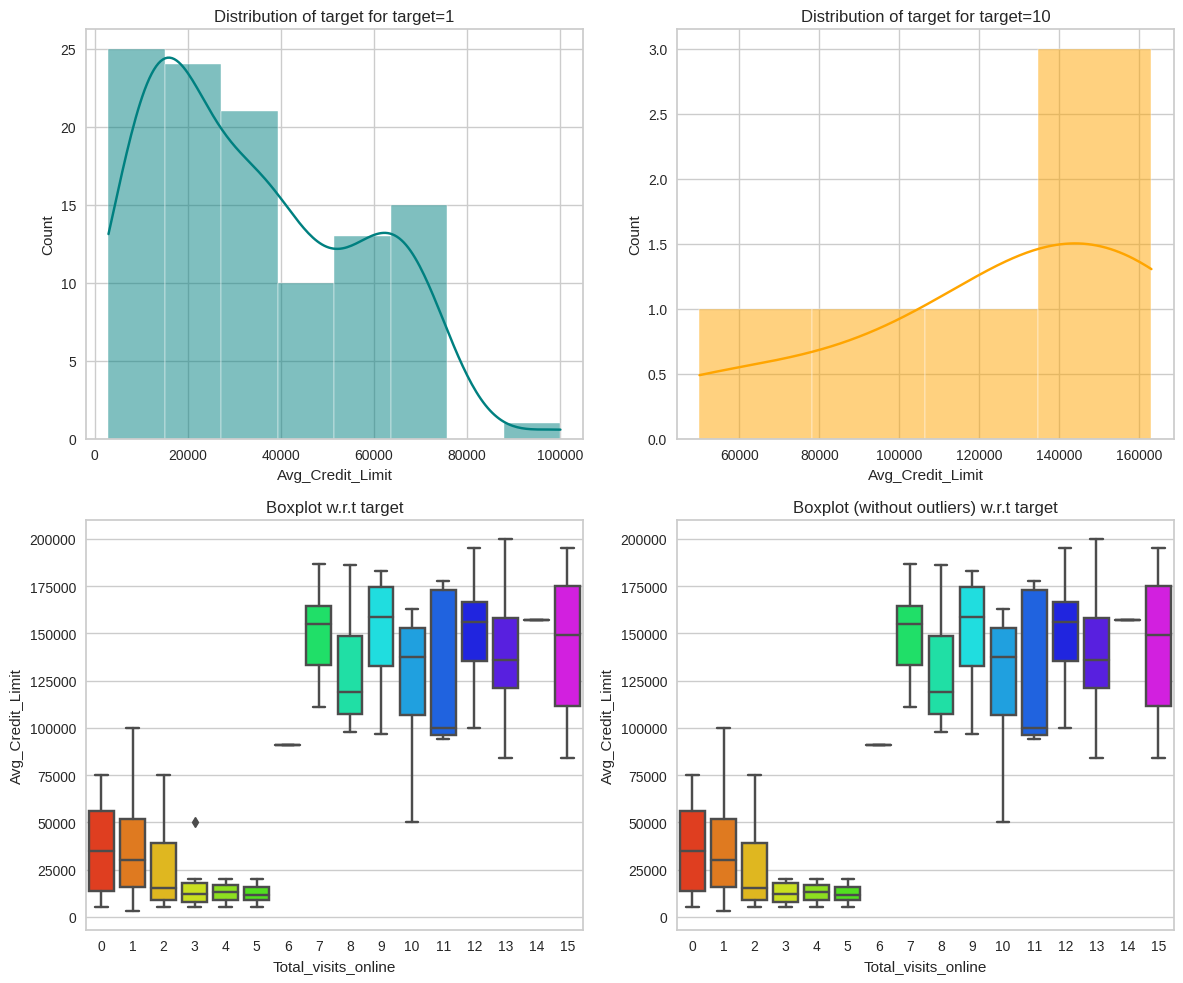

In [40]:
distribution_plot_wrt_target(df, "Avg_Credit_Limit", "Total_visits_online")

Those who have 5 or less Total_visits_online tend to have lower Avg_Credit_Limit than those who have a greater number of online visits.

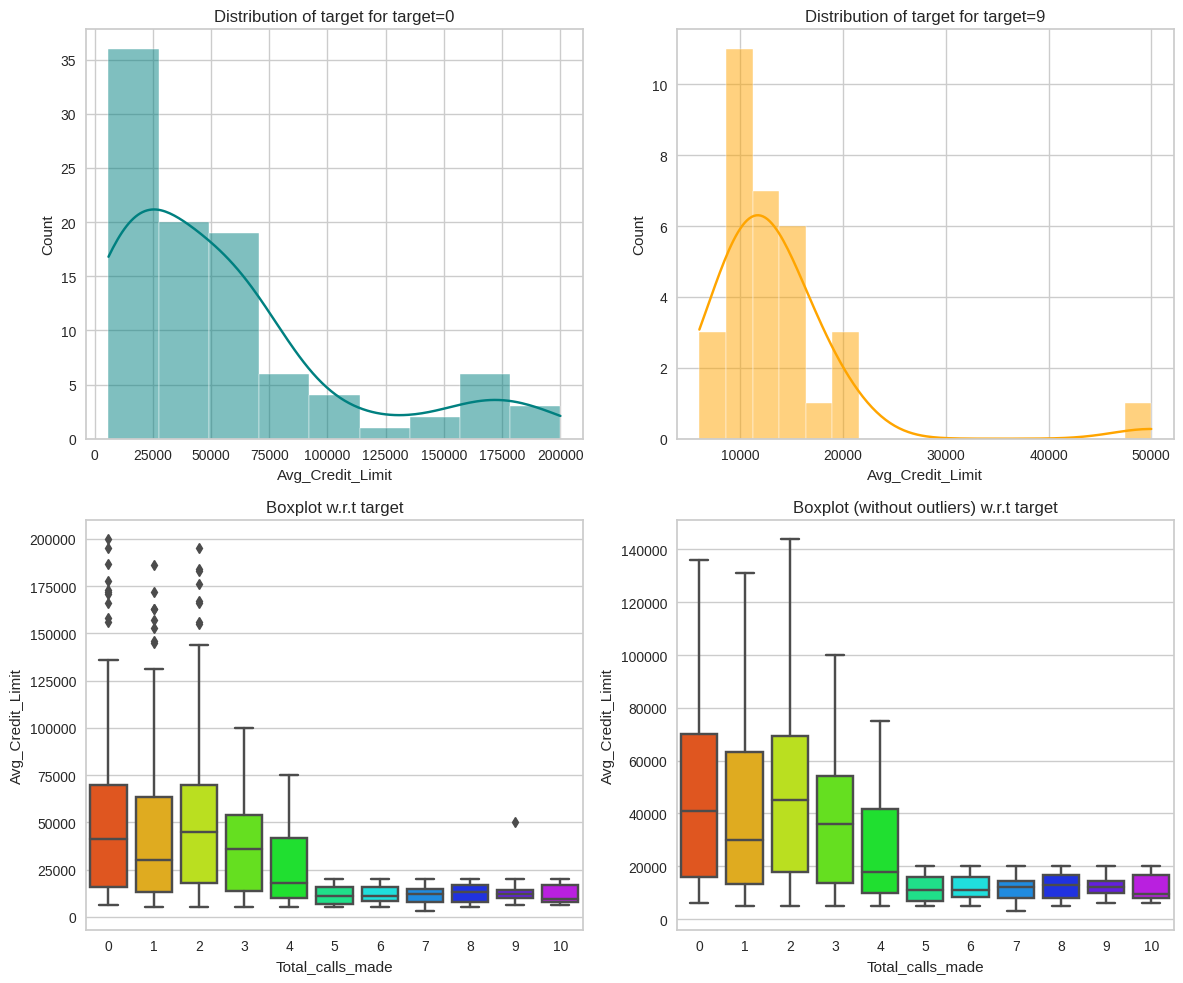

In [41]:
distribution_plot_wrt_target(df, "Avg_Credit_Limit", "Total_calls_made")

Those with 4 or fewer Total_calls_made have a greater Avg_Credit_Limit than those with 5 or greater Total_calls_made.  

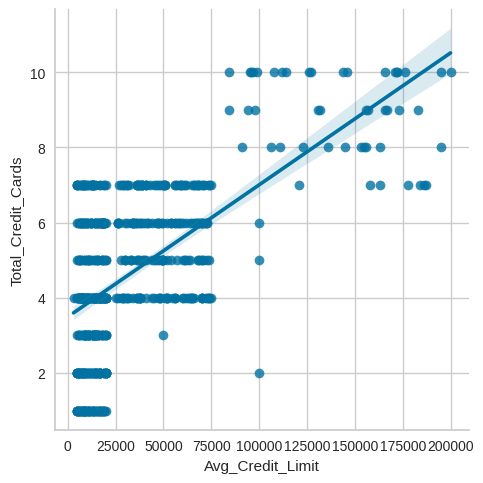

In [42]:
sns.lmplot(data=df, x = "Avg_Credit_Limit", y = "Total_Credit_Cards")

Avg_Credit_Limit and Total_Credit_Cards are strongly positively correlated.

### Heat Map Correlation Matrix

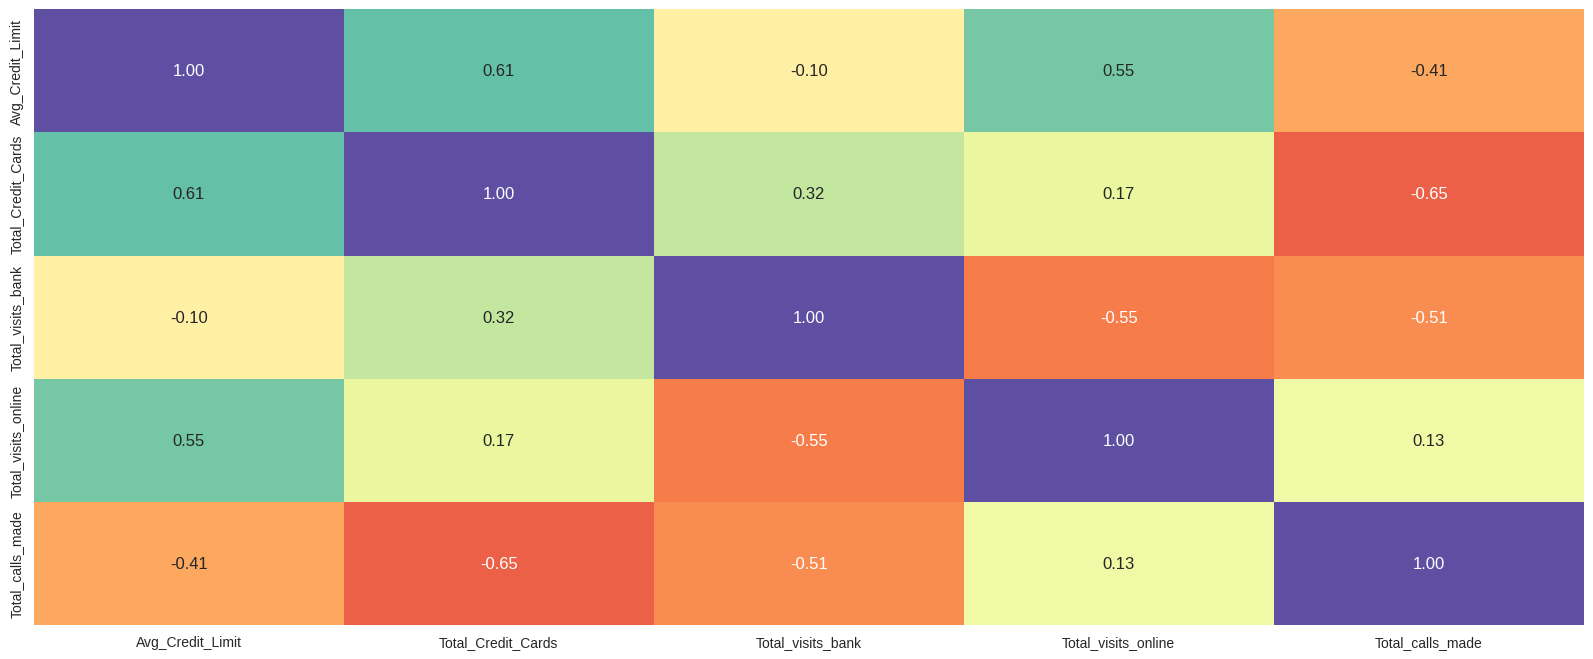

In [43]:
# Create correlation matrix and check for correlation among numerical values
num_var = ["Avg_Credit_Limit", "Total_Credit_Cards", "Total_visits_bank", "Total_visits_online", "Total_calls_made"]

corr = df[num_var].corr()

# plot the heatmap

plt.figure(figsize=(20, 8))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral", cbar=False)
plt.show()


* Avg_Credit_Limit is positively correlated with Total_visits_online and Total_Credit_Cards.
* Total_Credit_Cards is distributed somewhat normally and negatively correlated with Total_calls_made. It is positively  correlated with Avg_Credit_Limit.          
* Total_visits_bank has a weak negative correlation with Total_calls_made and Total_visits_online.   
* Total_visits_online is negatively correlated with Total_visits_bank and positively correlated with Avg_Credit_Limit.          * Total_calls_made is negatively correlated with Total_visits_bank and Total_Credit_Cards.

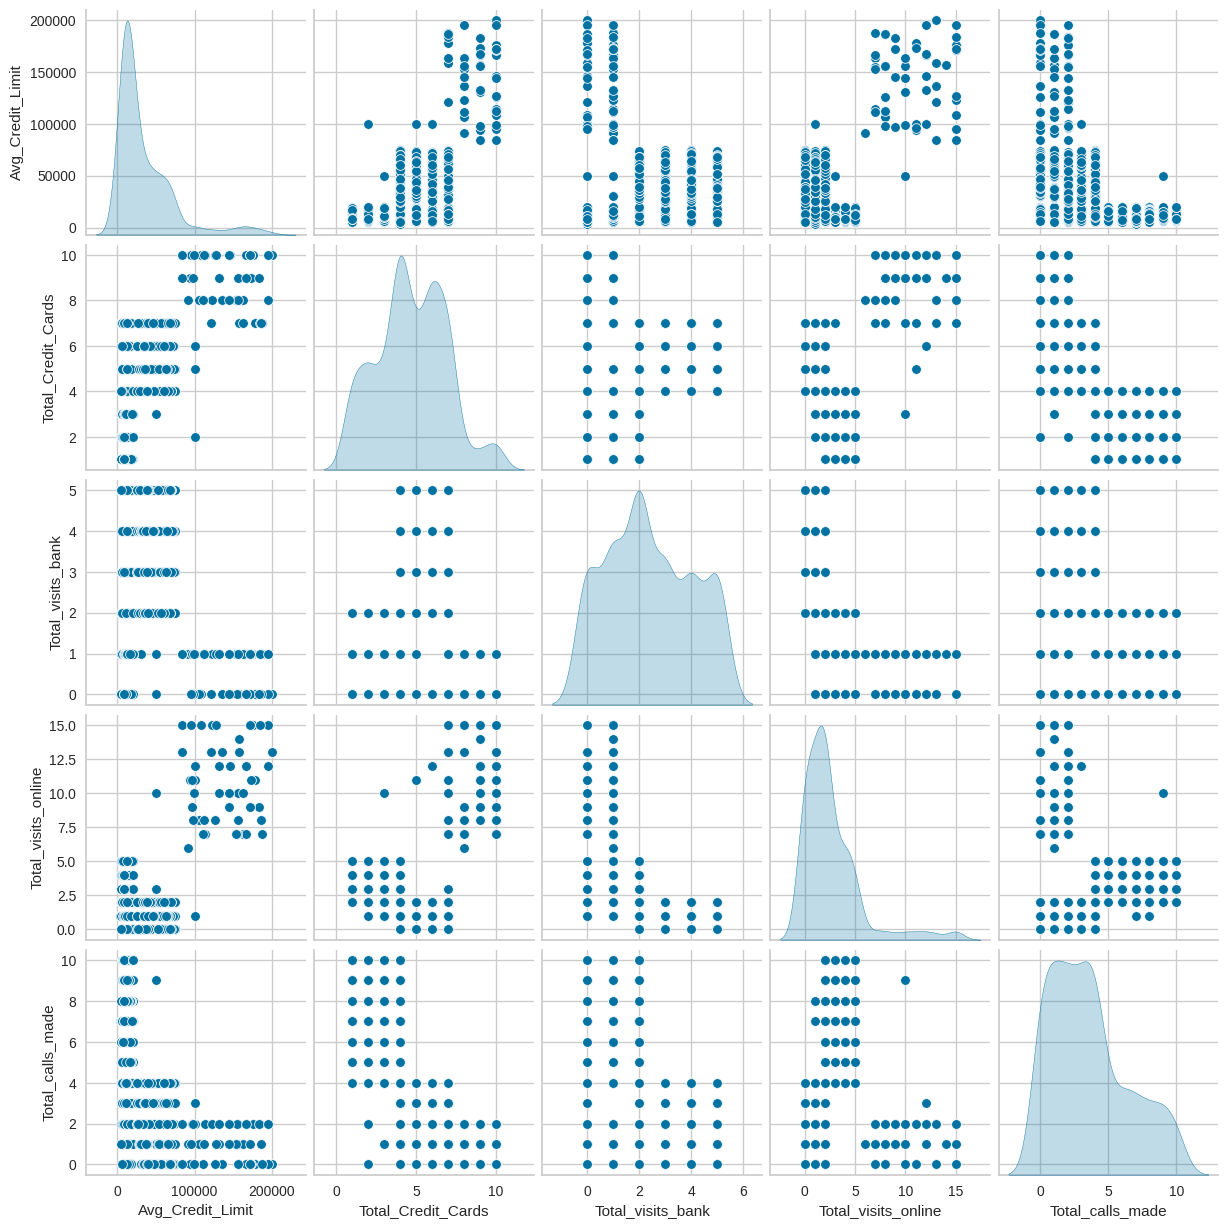

In [44]:
# Build a pairplot for numerical variables
sns.pairplot(data=df, diag_kind="kde")
plt.show()

* Avg_Credit_Limit is right skewed and positively correlated with Total_visits_online and Total_Credit_Cards.
* Total_Credit_Cards is negatively correlated with Total_calls_made and positively correlated with Avg_Credit_Limit.            * Total_visits_bank is right skewed and has a weak negative correlation with Total_calls_made and Total_visits_online.   
* Total_visits_online very right skewed and is negatively correlated with Total_visits_bank and positively correlated with Avg_Credit_Limit.          
* Total_calls_made is right skewed and is negatively correlated with Total_visits_bank and Total_Credit_Cards.

## Data Preprocessing

In [45]:
# Variables used for clustering
num_var

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [46]:
# Save a dataframe copy for use in clustering evaluations
df1 = df.copy()

In [47]:
# Scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_var].copy()
subset_scaled = scaler.fit_transform(subset)

In [48]:
# Creating a dataframe of the scaled columns to use for KMeans clustering
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [49]:
# Save copies of the scaled dataframe for later evaluation
subset_scaled_df1 = subset_scaled_df.copy()
subset_scaled_df2 = subset_scaled_df.copy()

### KMeans Clustering

Group Data into similar clusters
Now, we will use K-Means clustering to group data based on their attribute. First, we need to determine the optimal number of groups. For that we conduct the knee test to see where the knee happens.

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9094290022428964
Number of Clusters: 8 	Average Distortion: 0.8891380888508975


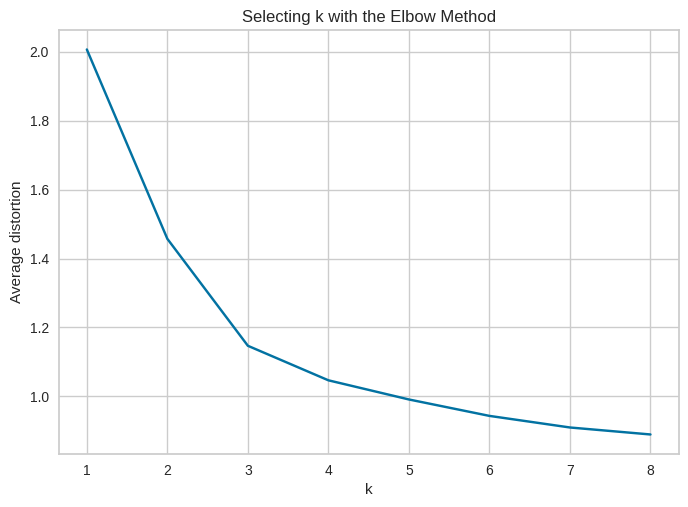

In [50]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

Optimum number of clusters appears to be between 2 and 4.  Compute silhoutte scores to determine optimum number of clusters.

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2717470361089752)
For n_clusters = 6, the silhouette score is 0.2560150493463967)
For n_clusters = 7, the silhouette score is 0.2484780407682755)
For n_clusters = 8, the silhouette score is 0.2261268477139729)
For n_clusters = 9, the silhouette score is 0.21993804286643806)


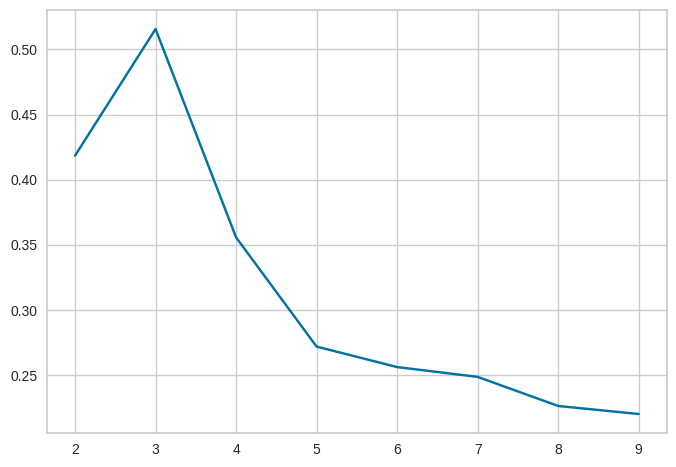

In [51]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

Maximum silhouette score is 0.5157 with n_clusters = 3

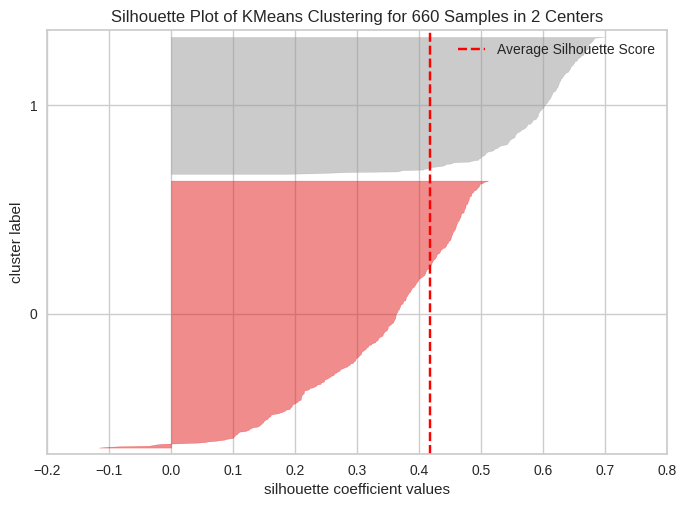

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [52]:
# finding optimal no. of clusters with silhouette coefficients - check n_clusters = 2
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

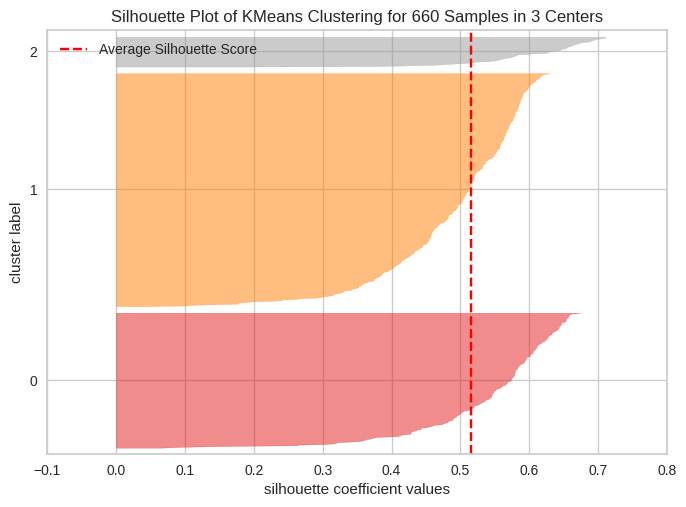

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [53]:
# finding optimal no. of clusters with silhouette coefficients - check n_clusters = 3
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

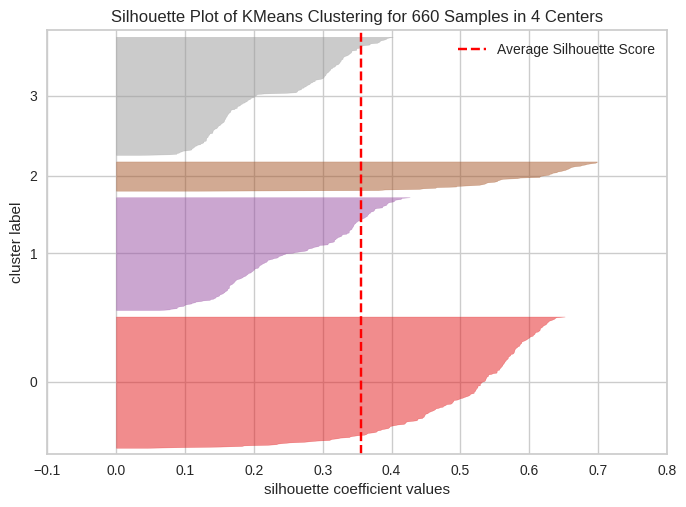

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [54]:
# finding optimal no. of clusters with silhouette coefficients- check n_clusters = 4
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

*The greatest silhouette score, 0.5157 is reached by n_clusters = 3.  All of the clusters exceed the 0.5157 threshold and all of the clusters are of different thickness.  This is the optimum number of clusters.

In [55]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

In [56]:
# Adding kmeans cluster labels to the original and scaled dataframes
df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

### Cluster Profiling

In [57]:
cluster_profile = df.groupby("K_means_segments").mean()

In [58]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [59]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

* Cluster 2 has the greatest mean Avg_Credit_Limit which is 141040.
* Cluster 2 has the greatest mean Total_Credit_Cards which is 8.74.
* Cluster 0 has the greatest mean Total_visits_bank which is 3.49.
* Cluster 2 has the greatest mean Total_visits_online which is 10.90.
* Cluster 1 has the greatest mean Total_calls_made which is 6.87.
* Cluster 0 has the greatest number of data points, which is 386. Cluster 1 has 224 data points and cluster 2 has 50 data points.

In [60]:
### Profile KMeans Clusters

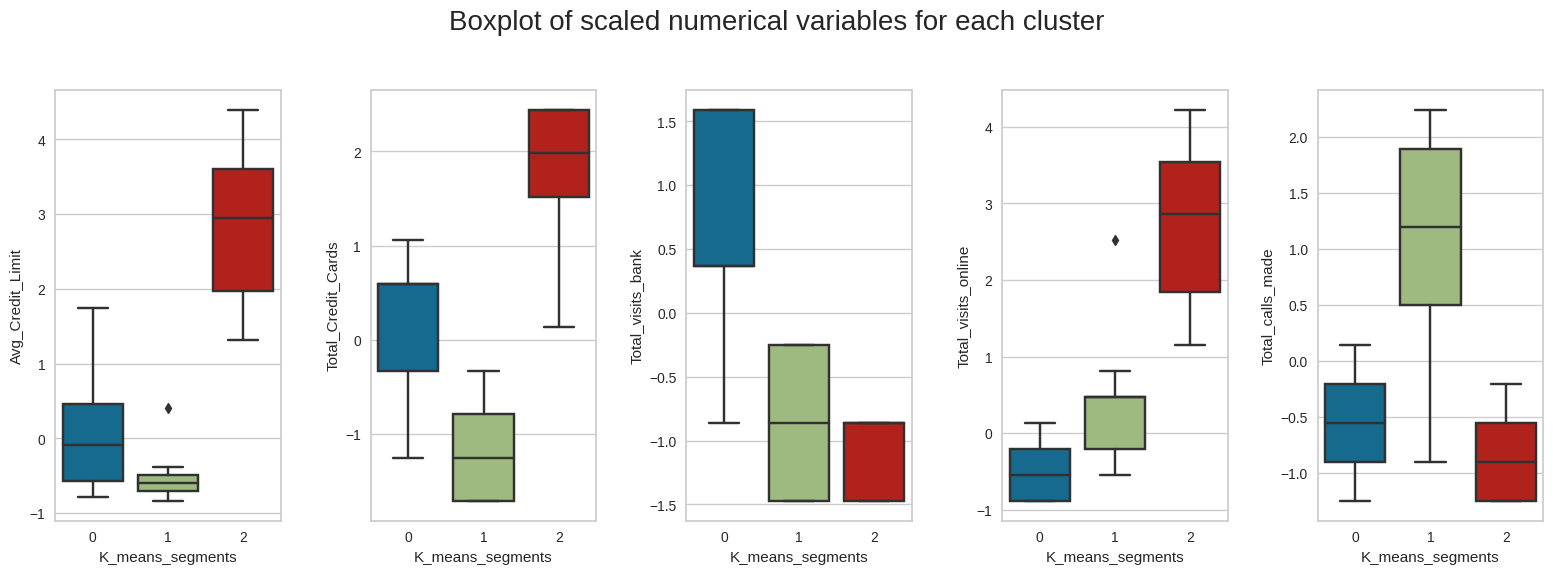

In [61]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_var[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

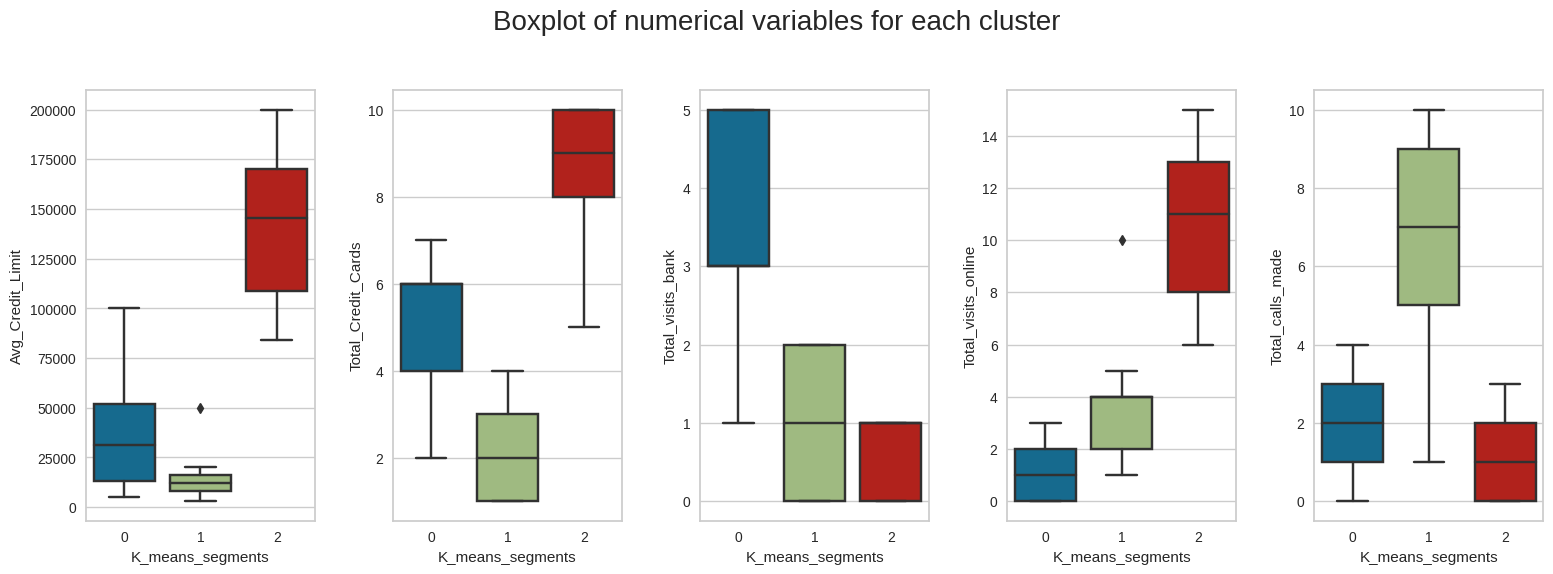

In [62]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=df[num_var[counter]],
        x=df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

* Cluster 0 is in the mid-range for Avg_Credit_Limit and Total_Credit_Cards.  
* Cluster 0 has the greatest Total_visits_bank and lowest Total_visits_online and is in the mid-range for Total_calls_made.     * Cluster 1 has the lowest Avg_Credit_Limit, lowest Total_Credit_Cards.
* Cluster 1 is in the mid-range for Total_visits_bank, and Total_visits_online. Cluster 1 has the greatest Total_calls_made.    * Cluster 2 has the greatest Avg_Credit_Limit, greatest Total_Credit_Cards, and lowest Total_visits_bank.
* Cluster 2 has the greatest Total_visits_online, and lowest Total_calls_made.

In [63]:
# Create a dataframe composed of points with K_means_segments = 0

In [64]:
df_km_seg0 = df[df["K_means_segments"] ==0]

In [65]:
df_km_seg0.describe().T

count          mean           std     min      25%  \
Avg_Credit_Limit     386.0  33782.383420  22169.460696  5000.0  13000.0   
Total_Credit_Cards   386.0      5.515544      1.140069     2.0      4.0   
Total_visits_bank    386.0      3.489637      1.135563     1.0      3.0   
Total_visits_online  386.0      0.981865      0.857167     0.0      0.0   
Total_calls_made     386.0      2.000000      1.430648     0.0      1.0   
K_means_segments     386.0      0.000000      0.000000     0.0      0.0   

                         50%      75%       max  
Avg_Credit_Limit     31000.0  52000.0  100000.0  
Total_Credit_Cards       6.0      6.0       7.0  
Total_visits_bank        3.0      5.0       5.0  
Total_visits_online      1.0      2.0       3.0  
Total_calls_made         2.0      3.0       4.0  
K_means_segments         0.0      0.0       0.0

### Cluster 0 Profile

* The total number of data points is 386.
* The Avg_Credit_Limit mean of 33782 is greater than the median value of 31000.
* The Avg_Credit_Limit 25% quartile is 13000 and the 75% quartile is 52000. There are no outliers.
* The Total_Credit_Cards  mean of 5.52 is less than the median value of 6.00.
* The Total_Credit_Cards 25% quartile is 4.00 and the 75% quartile is 6.00. There are no outliers.
* The Total_visits_bank mean of 3.49 is greater than the median value of 3.00.
* The Total_visits_bank 25% quartile is 3.00 and the 75% quartile is 5.00. There are no outliers.
* The Total_visits_online mean of 0.98 is greater than the median value of 1.00.
* The Total_visits_online 25% quartile is 0.00 and the 75% quartile is 2.00. There are no outliers.
* The Total_calls_made mean of 2.00 is greater than the median value of 2.00.
* The Total_calls_made 25% quartile is 1.00 and the 75% quartile is 3.00. There are no outliers.

In [66]:
# Create a dataframe composed of points with K_means_segments = 1

In [67]:
df_km_seg1 = df[df["K_means_segments"] ==1]

In [68]:
df_km_seg1.describe().T

count          mean          std     min     25%  \
Avg_Credit_Limit     224.0  12174.107143  5249.048524  3000.0  8000.0   
Total_Credit_Cards   224.0      2.410714     1.100783     1.0     1.0   
Total_visits_bank    224.0      0.933036     0.803567     0.0     0.0   
Total_visits_online  224.0      3.553571     1.218978     1.0     2.0   
Total_calls_made     224.0      6.870536     1.990161     1.0     5.0   
K_means_segments     224.0      1.000000     0.000000     1.0     1.0   

                         50%      75%      max  
Avg_Credit_Limit     12000.0  16000.0  50000.0  
Total_Credit_Cards       2.0      3.0      4.0  
Total_visits_bank        1.0      2.0      2.0  
Total_visits_online      4.0      4.0     10.0  
Total_calls_made         7.0      9.0     10.0  
K_means_segments         1.0      1.0      1.0

### Cluster 1 Profile

* The total number of data points is 224.
* The Avg_Credit_Limit mean of 12174.1 is greater than the median value of 12000.
* The Avg_Credit_Limit 25% quartile is 8000 and the 75% quartile is 16000. There are high outliers.
* The Total_Credit_Cards  mean of 2.41 is greater than the median value of 2.00.
* The Total_Credit_Cards 25% quartile is 1.00 and the 75% quartile is 3.00. There are no outliers.
* The Total_visits_bank mean of 0.93 is less than the median value of 1.00.
* The Total_visits_bank 25% quartile is 0.00 and the 75% quartile is 2.00. There are no outliers.
* The Total_visits_online mean of 3.55 is less than the median value of 4.00.
* The Total_visits_online 25% quartile is 5.00 and the 75% quartile is 9.00. There are high outliers.
* The Total_calls_made mean of 6.87 is less than the median value of 7.00.
* The Total_calls_made 25% quartile is 5.00 and the 75% quartile is 9.00. There are no outliers.

In [69]:
# Create a dataframe composed of points with K_means_segments = 2

In [70]:
df_km_seg2 = df[df["K_means_segments"] ==2]

In [71]:
df_km_seg2.describe().T

count       mean           std      min       25%  \
Avg_Credit_Limit      50.0  141040.00  34457.877272  84000.0  108750.0   
Total_Credit_Cards    50.0       8.74      1.274715      5.0       8.0   
Total_visits_bank     50.0       0.60      0.494872      0.0       0.0   
Total_visits_online   50.0      10.90      2.880264      6.0       8.0   
Total_calls_made      50.0       1.08      0.876915      0.0       0.0   
K_means_segments      50.0       2.00      0.000000      2.0       2.0   

                          50%       75%       max  
Avg_Credit_Limit     145500.0  170000.0  200000.0  
Total_Credit_Cards        9.0      10.0      10.0  
Total_visits_bank         1.0       1.0       1.0  
Total_visits_online      11.0      13.0      15.0  
Total_calls_made          1.0       2.0       3.0  
K_means_segments          2.0       2.0       2.0

### Cluster 2 Profile

* The total number of data points is 50.
* The Avg_Credit_Limit mean of 141040 is less than the median value of 145500.
* The Avg_Credit_Limit 25% quartile is 108750 and the 75% quartile is 170000. There are no outliers.
* The Total_Credit_Cards  mean of 8.74 is less than the median value of 9.00.
* The Total_Credit_Cards 25% quartile is 8.00 and the 75% quartile is 10.00. There are no outliers.
* The Total_visits_bank mean of 0.60 is less than the median value of 1.00.
* The Total_visits_bank 25% quartile is 0.00 and the 75% quartile is 1.00. There are no outliers.
* The Total_visits_online mean of 10.90 is less than the median value of 11.00.
* The Total_visits_online 25% quartile is 8.00 and the 75% quartile is 13.00. There are no outliers.
* The Total_calls_made mean of 1.08 is greater than the median value of 1.00.
* The Total_calls_made 25% quartile is 0.00 and the 75% quartile is 2.00. There are no outliers.

### Dimensionality Reduction using PCA for visualization
### Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [72]:
# importing library
from sklearn.decomposition import PCA

# setting the number of components to 2
pca = PCA(n_components=2)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(subset_scaled_df)
reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2"]
)

In [73]:
# checking the amount of variance explained
pca.explained_variance_ratio_.sum()

0.8341192302707268

In [74]:
print(
    "Explained variance per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

Explained variance per principal component: [0.43073777 0.40338146]


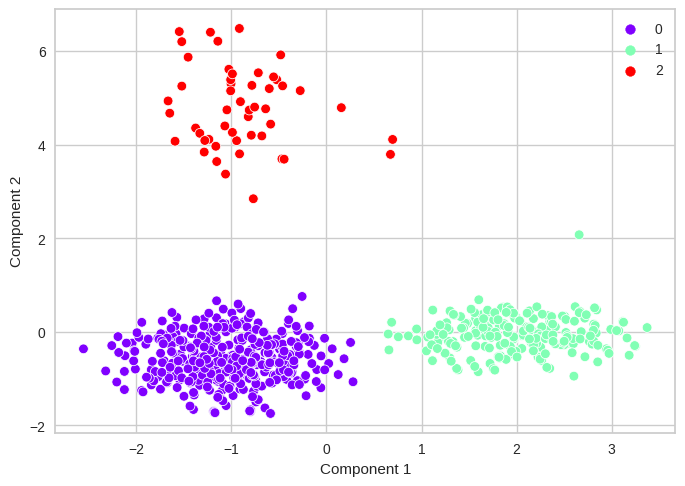

In [75]:
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=df["K_means_segments"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

Cluster 0 and cluster 1 are much more well defined than cluster 2. A 2 dimensional chart will also be plotted with hierarchical clustering input for comparison.

## Hierarchical Clustering

### Calculate cophenetic correlation

In [76]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df1, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df1))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875362.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.832723250944664.
Cophenetic cor

In [77]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


###   Use of euclidean distance is appropriate.  Further investigation of linkage methods using euclidean distance

In [78]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df1, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df1))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [79]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


### Plot the dendrogram for each method

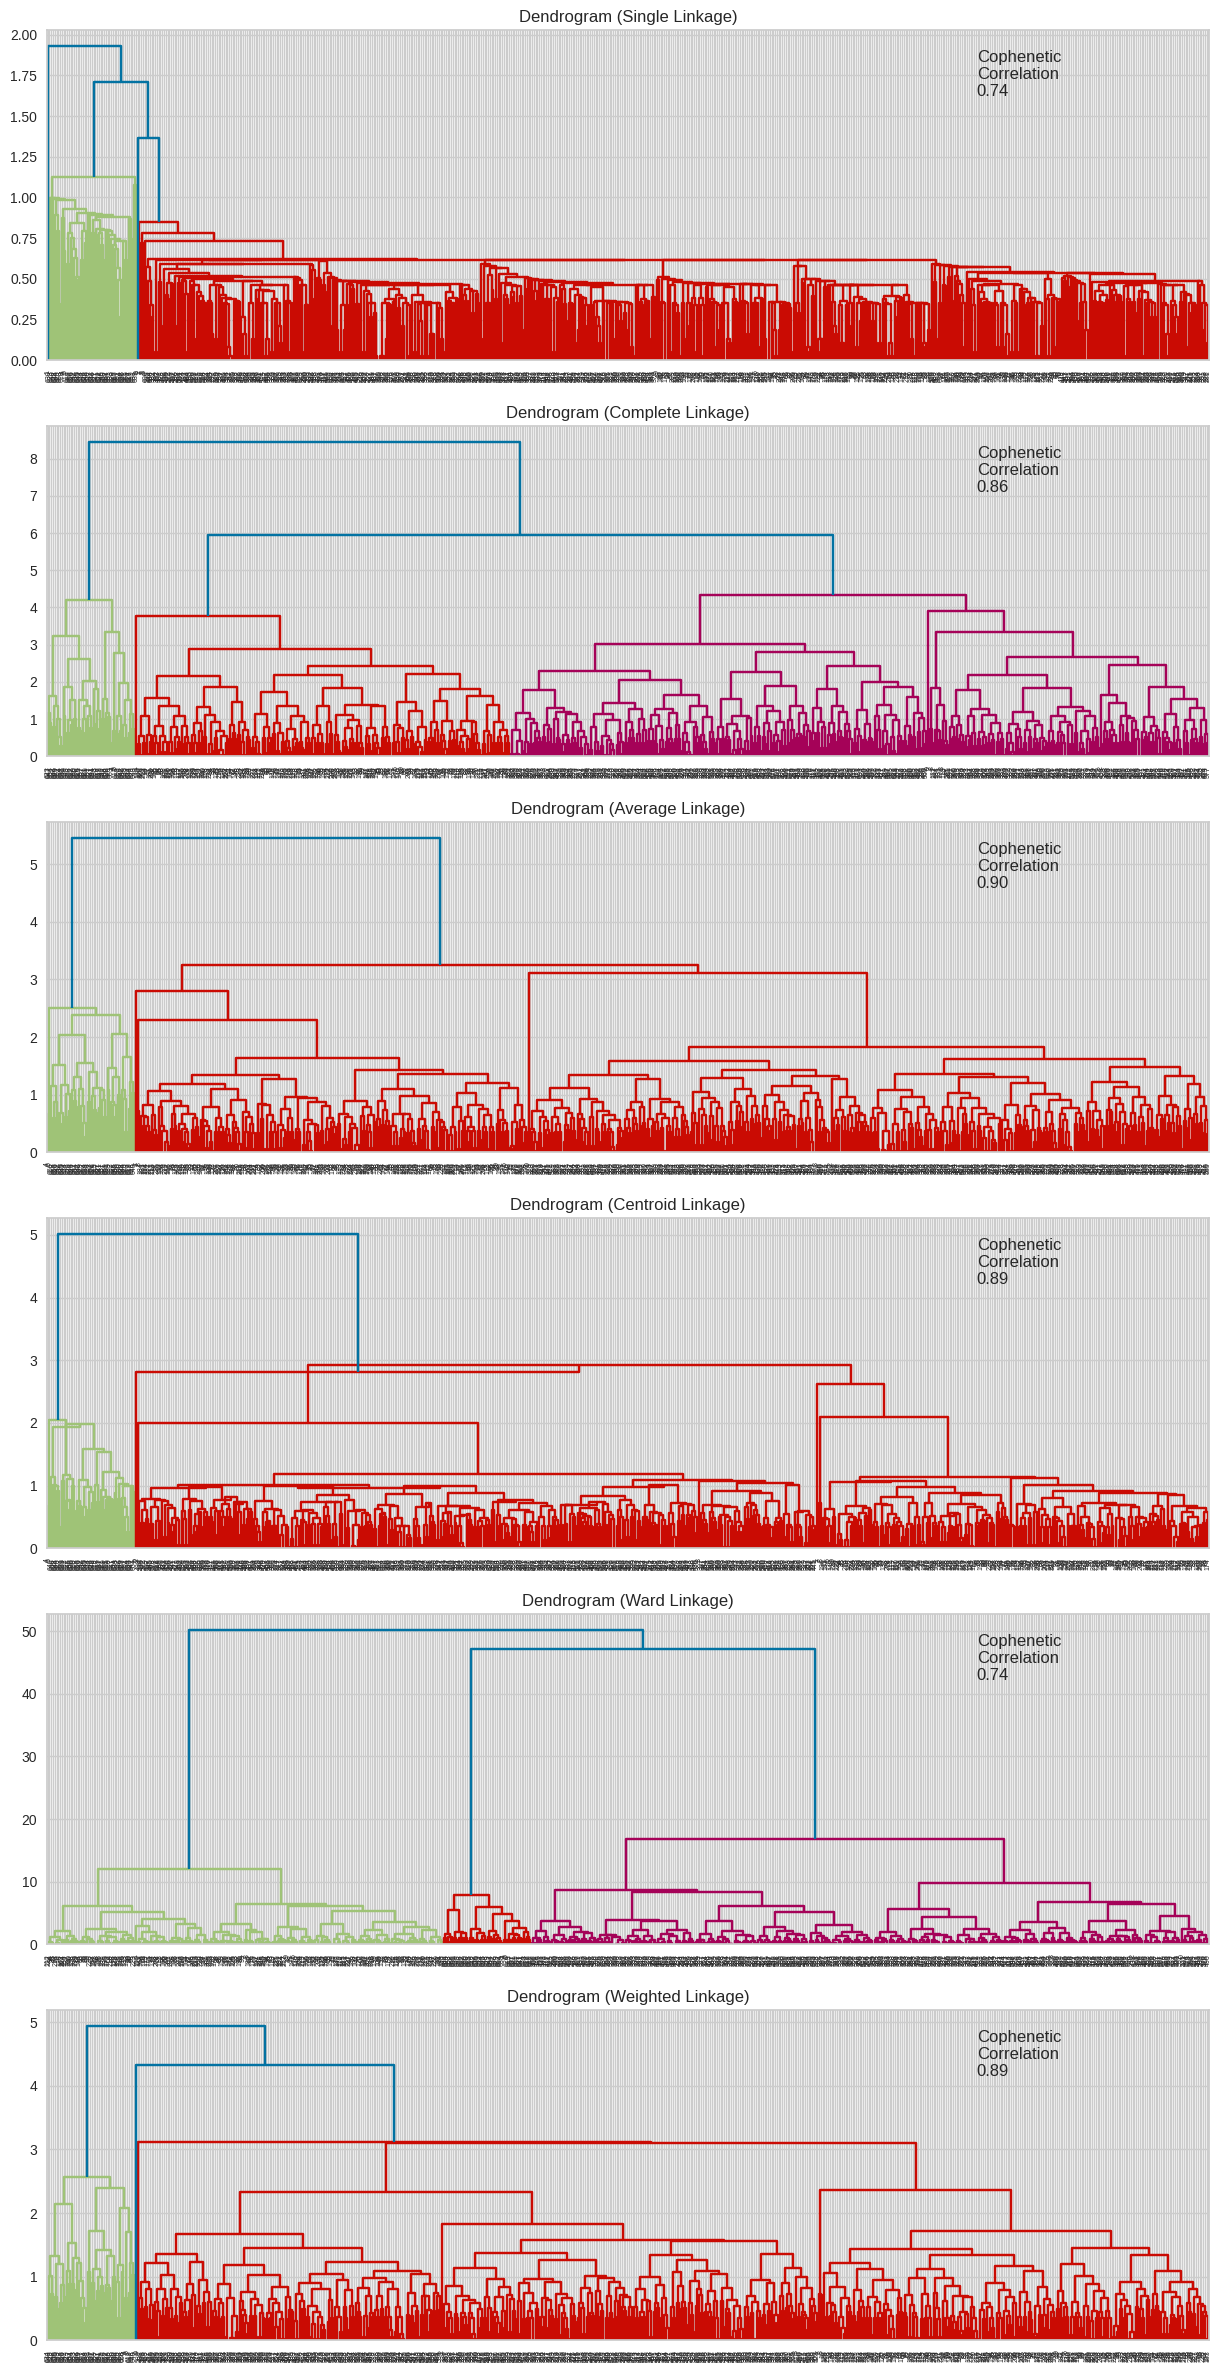

In [80]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df1, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df1))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

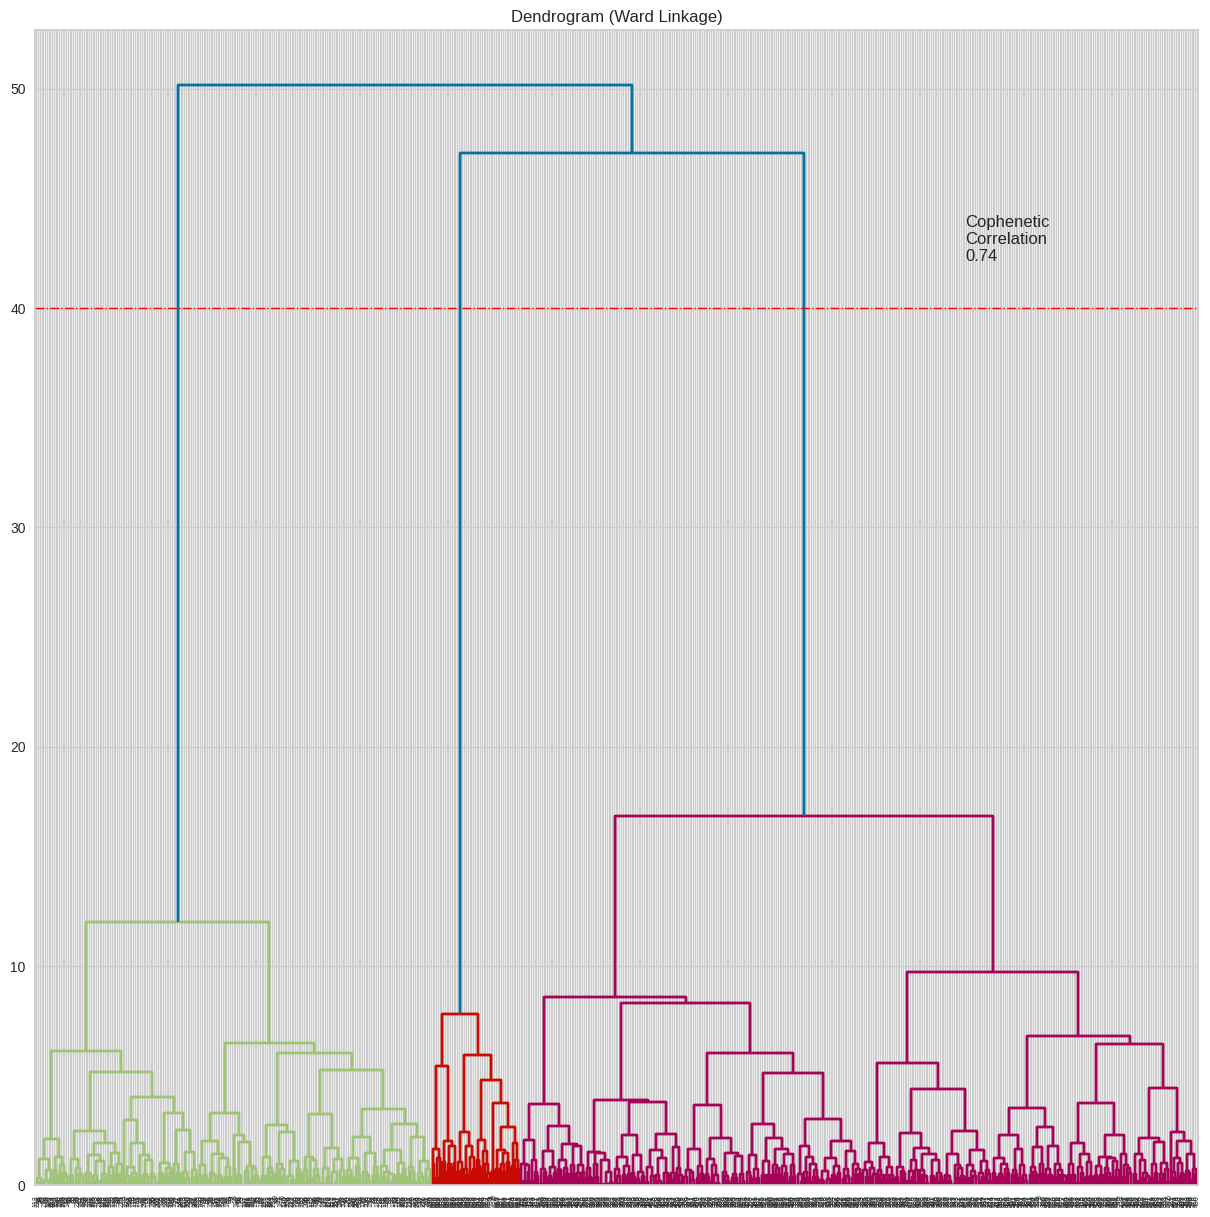

In [81]:
# Perform further investigation using the Ward linkage method and Euclidean Distance
linkage_methods = ["ward"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df1, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df1))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=40)
plt.axhline(y=40, c="red", lw=1, linestyle="dashdot")

### Dendrogram above indicates very clear clustering into 3 clusters
### Perform agglomerative clustering with euclidean distance metric and ward linkage and n_clusters = 3

In [82]:
# Use ward linkage with 3 clusters
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df1)

AgglomerativeClustering(affinity='euclidean', n_clusters=3)

In [83]:
#  Add HC_Clusters labels to original and scaled dataset
subset_scaled_df1["HC_Clusters"] = HCmodel.labels_
df1["HC_Clusters"] = HCmodel.labels_

In [84]:
## Agglomerative cluster profiling
cluster_profile = df1.groupby("HC_Clusters").mean()


In [85]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

* Cluster 2 has the greatest mean Avg_Credit_Limit which is 141040.
* Cluster 2 has the greatest mean Total_Credit_Cards which is 8.74.
* Cluster 0 has the greatest mean Total_visits_bank which is 3.49.
* Cluster 2 has the greatest mean Total_visits_online which is 10.90.
* Cluster 1 has the greatest mean Total_calls_made which is 6.86.


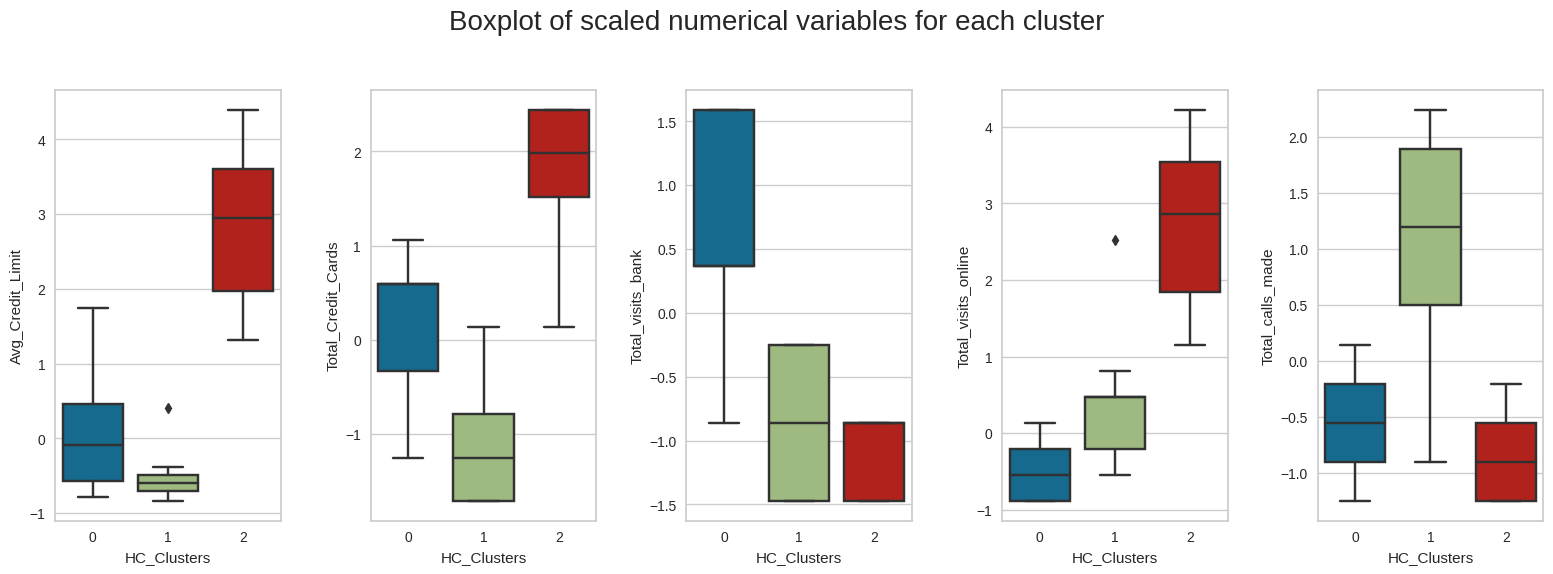

In [86]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df1[num_var[counter]],
        x=subset_scaled_df1["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

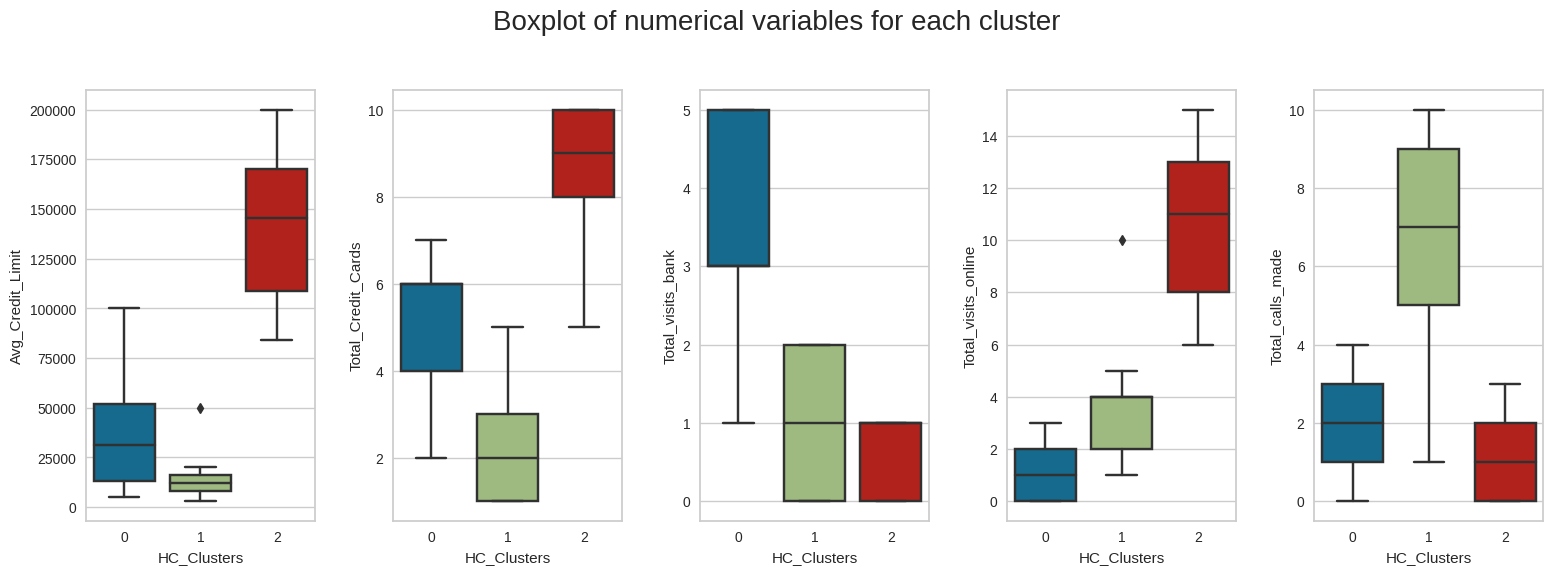

In [87]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=df1[num_var[counter]],
        x=df1["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

* Cluster 0 is in the mid-range for Avg_Credit_Limit and Total_Credit_Cards.  
* Cluster 0 has the greatest Total_visits_bank and lowest Total_visits_online and is in the mid-range for Total_calls_made.     * Cluster 1 has the lowest Avg_Credit_Limit, lowest Total_Credit_Cards.
* Cluster 1 is in the mid-range for Total_visits_bank, and Total_visits_online. Cluster 1 has the greatest Total_calls_made.    * Cluster 2 has the greatest Avg_Credit_Limit, greatest Total_Credit_Cards, and lowest Total_visits_bank.
* Cluster 2 has the greatest Total_visits_online, and lowest Total_calls_made.

Compute Silhouette Score For Agglomerative Clustering For Comparison With KMeans

In [88]:
sil_score = []
nclusters = 3
clusterer = AgglomerativeClustering(nclusters, affinity = "euclidean", linkage = "ward")
preds = clusterer.fit_predict((subset_scaled_df1))
#centers = clusterer.cluster_centers_
score = silhouette_score(subset_scaled_df1, preds)
#sil_score.append(score)
print("For n_clusters = {}, the silhouette score is {})".format(nclusters, score))

For n_clusters = 3, the silhouette score is 0.5403161639178303)


###  Cluster Profiling

In [89]:
# Create a dataframe composed of points with HC_Clusters = 0

In [90]:
df_hc_cluster0 = df1[df1["HC_Clusters"]==0]

In [91]:
df_hc_cluster0.describe().T

count          mean           std     min      25%  \
Avg_Credit_Limit     385.0  33851.948052  22156.084628  5000.0  13000.0   
Total_Credit_Cards   385.0      5.516883      1.141249     2.0      4.0   
Total_visits_bank    385.0      3.493506      1.134490     1.0      3.0   
Total_visits_online  385.0      0.979221      0.856704     0.0      0.0   
Total_calls_made     385.0      1.994805      1.428860     0.0      1.0   
HC_Clusters          385.0      0.000000      0.000000     0.0      0.0   

                         50%      75%       max  
Avg_Credit_Limit     31000.0  52000.0  100000.0  
Total_Credit_Cards       6.0      6.0       7.0  
Total_visits_bank        3.0      5.0       5.0  
Total_visits_online      1.0      2.0       3.0  
Total_calls_made         2.0      3.0       4.0  
HC_Clusters              0.0      0.0       0.0

In [92]:
#Print number of visits online for cluster 0
print(df_hc_cluster0["Total_visits_online"].value_counts())

0    144
2    134
1    106
3      1
Name: Total_visits_online, dtype: int64


In [93]:
#Print number of Total_calls_made for cluster 0
print(df_hc_cluster0["Total_calls_made"].value_counts())

3    82
0    81
4    76
1    74
2    72
Name: Total_calls_made, dtype: int64


In [94]:
#Print number of Total_visits_bank for cluster 0
print(df_hc_cluster0["Total_visits_bank"].value_counts())

3    100
5     98
2     92
4     92
1      3
Name: Total_visits_bank, dtype: int64


### Cluster 0 Profile

* The total number of data points is 385.
* The Avg_Credit_Limit mean of 33851.9 is greater than the median value of 31000.
* The Avg_Credit_Limit 25% quartile is 13000 and the 75% quartile is 52000. There are no outliers.
* The Total_Credit_Cards  mean of 5.52 is less than the median value of 6.00.
* The Total_Credit_Cards 25% quartile is 4.00 and the 75% quartile is 6.00. There are no outliers.
* The Total_visits_bank mean of 3.49 is greater than the median value of 3.00.
* The Total_visits_bank 25% quartile is 3.00 and the 75% quartile is 5.00. There are no outliers.
* The Total_visits_online mean of 0.98 is greater than the median value of 1.00.
* The Total_visits_online 25% quartile is 0.00 and the 75% quartile is 2.00. There are no outliers.
* The Total_calls_made mean of 1.99 is greater than the median value of 2.00.
* The Total_calls_made 25% quartile is 0.00 and the 75% quartile is 3.00. There are no outliers.

In [95]:
# Create a dataframe composed of points with HC_Clusters = 1

In [96]:
df_hc_cluster1 = df1[df1["HC_Clusters"]==1]

In [97]:
df_hc_cluster1.describe().T

count          mean          std     min     25%  \
Avg_Credit_Limit     225.0  12151.111111  5248.665741  3000.0  8000.0   
Total_Credit_Cards   225.0      2.422222     1.111805     1.0     1.0   
Total_visits_bank    225.0      0.937778     0.804920     0.0     0.0   
Total_visits_online  225.0      3.546667     1.220656     1.0     2.0   
Total_calls_made     225.0      6.857778     1.994914     1.0     5.0   
HC_Clusters          225.0      1.000000     0.000000     1.0     1.0   

                         50%      75%      max  
Avg_Credit_Limit     12000.0  16000.0  50000.0  
Total_Credit_Cards       2.0      3.0      5.0  
Total_visits_bank        1.0      2.0      2.0  
Total_visits_online      4.0      4.0     10.0  
Total_calls_made         7.0      9.0     10.0  
HC_Clusters              1.0      1.0      1.0

In [98]:
#Print number of visits online for cluster 1
print(df_hc_cluster1["Total_visits_online"].value_counts())

4     69
2     55
5     54
3     43
1      3
10     1
Name: Total_visits_online, dtype: int64


In [99]:
#Print number of Total_calls_made for cluster 1
print(df_hc_cluster1["Total_calls_made"].value_counts())

6     39
7     35
9     32
4     32
8     30
5     29
10    26
1      1
2      1
Name: Total_calls_made, dtype: int64


In [100]:
#Print number of Total_visits_bank for cluster 1
print(df_hc_cluster1["Total_visits_bank"].value_counts())

0    80
1    79
2    66
Name: Total_visits_bank, dtype: int64


### Cluster 1 Profile

* The total number of data points is 225.
* The Avg_Credit_Limit mean of 12151 is greater than the median value of 12000.
* The Avg_Credit_Limit 25% quartile is 8000 and the 75% quartile is 16000 There are high outliers.
* The Total_Credit_Cards  mean of 1.00 is less than the median value of 2.00.
* The Total_Credit_Cards 25% quartile is 1.00 and the 75% quartile is 3.00. There are no outliers.
* The Total_visits_bank mean of 0.94 is less than the median value of 1.00.
* The Total_visits_bank 25% quartile is 0.00 and the 75% quartile is 2.00. There are no outliers.
* The Total_visits_online mean of 3.55 is less than the median value of 4.00.
* The Total_visits_online 25% quartile is 2.00 and the 75% quartile is 4.00. There are high outliers.
* The Total_calls_made mean of 6.86 is less than the median value of 7.00.
* The Total_calls_made 25% quartile is 5.00 and the 75% quartile is 9.00. There are no outliers.

In [101]:
# Create a dataframe composed of points with HC_Clusters = 2

In [102]:
df_hc_cluster2 = df1[df1["HC_Clusters"]==2]

In [103]:
df_hc_cluster2.describe().T

count       mean           std      min       25%  \
Avg_Credit_Limit      50.0  141040.00  34457.877272  84000.0  108750.0   
Total_Credit_Cards    50.0       8.74      1.274715      5.0       8.0   
Total_visits_bank     50.0       0.60      0.494872      0.0       0.0   
Total_visits_online   50.0      10.90      2.880264      6.0       8.0   
Total_calls_made      50.0       1.08      0.876915      0.0       0.0   
HC_Clusters           50.0       2.00      0.000000      2.0       2.0   

                          50%       75%       max  
Avg_Credit_Limit     145500.0  170000.0  200000.0  
Total_Credit_Cards        9.0      10.0      10.0  
Total_visits_bank         1.0       1.0       1.0  
Total_visits_online      11.0      13.0      15.0  
Total_calls_made          1.0       2.0       3.0  
HC_Clusters               2.0       2.0       2.0

In [104]:
#Print number of visits online for cluster 2
print(df_hc_cluster2["Total_visits_online"].value_counts())

15    10
7      7
12     6
8      6
11     5
10     5
13     5
9      4
14     1
6      1
Name: Total_visits_online, dtype: int64


In [105]:
#Print number of Total_calls_made for cluster 2
print(df_hc_cluster2["Total_calls_made"].value_counts())

2    18
0    16
1    15
3     1
Name: Total_calls_made, dtype: int64


In [106]:
# Calculate sum of Total_visits_online
sum_visits_online = (df_hc_cluster0["Total_visits_online"].sum()) + (df_hc_cluster1["Total_visits_online"].sum()) + (df_hc_cluster2["Total_visits_online"].sum())
sum_visits_online

1720

In [107]:
# Calculate sum of Total_calls_made
sum_calls = (df_hc_cluster0["Total_calls_made"].sum()) + (df_hc_cluster1["Total_calls_made"].sum()) + (df_hc_cluster2["Total_calls_made"].sum())
sum_calls

2365

In [108]:
# Calculate sum of Total_visits_bank
sum_bank_visits = (df_hc_cluster0["Total_visits_bank"].sum()) + (df_hc_cluster1["Total_visits_bank"].sum()) + (df_hc_cluster2["Total_visits_bank"].sum())
sum_bank_visits

1586

### Cluster 2 Profile

* The total number of data points is 50.
* The Avg_Credit_Limit mean of 141040 is less than the median value of 145500.
* The Avg_Credit_Limit 25% quartile is 108750 and the 75% quartile is 170000 There are no outliers.
* The Total_Credit_Cards  mean of 8.74 is less than the median value of 9.00.
* The Total_Credit_Cards 25% quartile is 8.00 and the 75% quartile is 10.00. There are no outliers.
* The Total_visits_bank mean of 0.60 is less than the median value of 1.00.
* The Total_visits_bank 25% quartile is 0.00 and the 75% quartile is 1.00. There are no outliers.
* The Total_visits_online mean of 10.90 is less than the median value of 11.00.
* The Total_visits_online 25% quartile is 8.00 and the 75% quartile is 13.00. There are no outliers.
* The Total_calls_made mean of 1.08 is greater than the median value of 7.00.
* The Total_calls_made 25% quartile is 0.00 and the 75% quartile is 2.00. There are no outliers.

###  Dimensionality Reduction using PCA for visualization

In [109]:
# importing library
from sklearn.decomposition import PCA

# setting the number of components to 2
pca = PCA(n_components=2)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(subset_scaled_df1)
reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2"]
)

In [110]:
# checking the amount of variance explained
pca.explained_variance_ratio_.sum()

0.8340792803324285

In [111]:
print(
    "Explained variance per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

Explained variance per principal component: [0.43077502 0.40330426]


In [112]:
df1.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000                   2                  1   
1             50000                   3                  0   
2             50000                   7                  1   
3             30000                   5                  1   
4            100000                   6                  0   

   Total_visits_online  Total_calls_made  HC_Clusters  
0                    1                 0            0  
1                   10                 9            1  
2                    3                 4            0  
3                    1                 4            0  
4                   12                 3            2

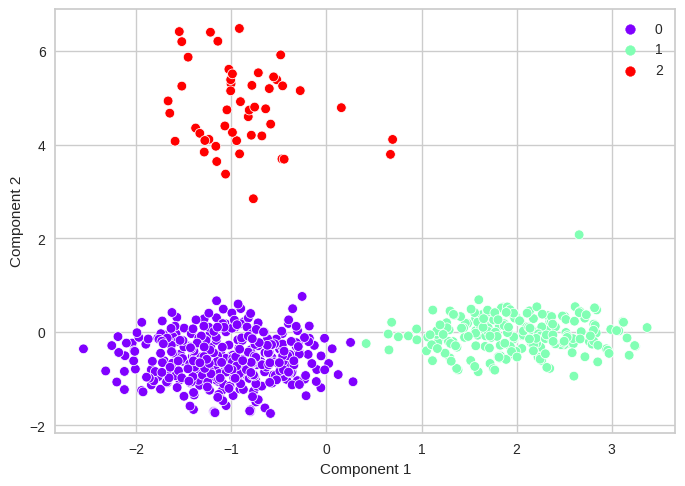

In [113]:
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=df1["HC_Clusters"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

* Cluster 0, cluster 1, and cluster 2 groupings for agglomerative clustering are quite similar to the groupings using K-means clustering. Cluster 0 and cluster 1 are more densely grouped than cluster 2.

### Compare K-means and Agglomerative clustering results

In [114]:
kmean_frame = pd.DataFrame(
    {
        "Cluster": [
            "Cluster 0",
            "Cluster 1",
            "Cluster 2",
             ],
        "Mean Avg_Credit_Limit": [33782.38, 12174.11, 141040.00],
        "Mean Total_Credit_Cards": [5.52, 2.41, 8.74],
        "Mean Total_visits_bank": [3.49, 0.93, 0.60],
        "Mean Total_visits_online": [0.98, 3.55, 10.90],
        "Mean Total_calls_made": [2.00, 6.87,1.08],
        "Total Count_in_each_segment" : [386,224,50]
    }
)


In [115]:
agg_frame = pd.DataFrame(
    {
        "Cluster": [
            "Cluster 0",
            "Cluster 1",
            "Cluster 2",
             ],
        "Mean Avg_Credit_Limit": [33851.95, 12151.11, 141040.00],
        "Mean Total_Credit_Cards": [5.52, 2.42, 8.74],
        "Mean Total_visits_bank": [3.49, 0.94, 0.60],
        "Mean Total_visits_online": [0.98, 3.55, 10.90],
        "Mean Total_calls_made": [1.99, 6.86,1.08],
        "Total Count_in_each_segment" : [385,225,50]
    }
)


In [116]:
# Data for K-means clustering
km_clusters = 3
km_sil_score = 0.5157
km_pca_var_exp = "83.41%"
# Data for agglomerative clustering
agg_clusters = 3
agg_sil_score = 0.5403
agg_pca_var_exp = "83.40%"
agg_dist = "Euclidean"
agg_link = "Ward"
agg_cophenetic = 0.7415

In [117]:
print("For K means, n_clusters is {}, silhouette score is {}, PCA variance explanation is {})".format(km_clusters, km_sil_score, km_pca_var_exp))
kmean_frame


For K means, n_clusters is 3, silhouette score is 0.5157, PCA variance explanation is 83.41%)


Cluster  Mean Avg_Credit_Limit  Mean Total_Credit_Cards  \
0  Cluster 0               33782.38                     5.52   
1  Cluster 1               12174.11                     2.41   
2  Cluster 2              141040.00                     8.74   

   Mean Total_visits_bank  Mean Total_visits_online  Mean Total_calls_made  \
0                    3.49                      0.98                   2.00   
1                    0.93                      3.55                   6.87   
2                    0.60                     10.90                   1.08   

   Total Count_in_each_segment  
0                          386  
1                          224  
2                           50

In [118]:
print("For Agglomerative clustering, n_clusters is {}, silhouette score is {}, PCA variance explanation is {}, distance method is {}, linkage is {}, cophenetic correlation is {}".format(agg_clusters, agg_sil_score, agg_pca_var_exp, agg_dist, agg_link,  agg_cophenetic))
agg_frame

For Agglomerative clustering, n_clusters is 3, silhouette score is 0.5403, PCA variance explanation is 83.40%, distance method is Euclidean, linkage is Ward, cophenetic correlation is 0.7415


Cluster  Mean Avg_Credit_Limit  Mean Total_Credit_Cards  \
0  Cluster 0               33851.95                     5.52   
1  Cluster 1               12151.11                     2.42   
2  Cluster 2              141040.00                     8.74   

   Mean Total_visits_bank  Mean Total_visits_online  Mean Total_calls_made  \
0                    3.49                      0.98                   1.99   
1                    0.94                      3.55                   6.86   
2                    0.60                     10.90                   1.08   

   Total Count_in_each_segment  
0                          385  
1                          225  
2                           50

The results for K-means and Hierarchical clustering are very close:
* Clustering: Analysis using both methods indicated that the optimum number of clusters is 3. The number of points in each of the clusters is almost identical for the three clusters.  Cluster 0 has the largest number of points followed by cluster 1 and cluster 2.  Cluster 2 is much smaller than the other two clusters with only 50 data points.
* The silhouette score for Agglomerative clustering is 0.5403 and the silhouette score for K-means clustering is slightly lower at 0.5157.
* Two dimensional visual comparison of clustering: For both clustering methods cluster 0 and cluster 1 are relatively well defined and the cluster 2 point grouping is less dense. The relative positioning of the clusters is the same for both clustering methods.
* PCA Analysis - The scaled K-means cluster data was reduced to two features for visualization of results for both methods and the PCA analysis predicted 83.41% o the variance for K-means and 83.40% of the variance for Agglomerative clustering.
* The tables above show a comparison of results for the two clustering methods.  The mean values for all features for each of the two clustering methods are almost identical.
* K-means clustering resulted in 386 data points in cluster 0 and 224 data points in cluster 1.  Agglomerative clustering resulted in 385 data points in cluster 0 and 225 data points in cluster 1.

#  Actionable Insights and Recommendations

The actionable insights and recommendations are based on the Agglomerative Clustering results.  Although the cluster results are very similar for the two clustering methods, Agglomerative clustering is selected as the superior method as the silhouette score for this method is slightly greater than the silhouette score for K-means clustering.

* Online access to banking services is very underutilized. Of the total customer interactions with the bank, only 30.3% is online, while 41.7% of customer interaction with the bank is by phone call and 28.0% of customer interaction with the bank is by physical visit to the bank.
* There needs to be outreach to customers, particularly to those in cluster 0 to encourage them enroll in online access and use it. The Total_visits_online is 0 for a total of 144 clients or 21.8% of the clients in the overall data set. All of these clients are in cluster 0.
* The web interface needs to be upgraded to be more user friendly.  The Total_visits_online is 1 for a total of 109 or 16.5% of the total clients in the dataset. The number of cluster 0 clients with Total_visits_online is 1 comprises 106 of the 109 customers who visited only one time.  
* There is a strong correlation between Avg_Credit_Limit and the percent of customer interactions with the bank that are done online. Recruitment of additional high income customers (those with high credit limits) will depend heavily on a user friendly web interface.
* New customers should be recruited through social media advertising and thus a very usable and attractive web interface will help with new customer recruitment.
* Consider making the online access multi-lingual friendly. The incidence of customers who only understand foreign languages may account for some of the count for Total_visits_online equals 1.
* The bank should educate customers on the benefits of the services available over the telephone. The Total_calls_made is 0 for a total of 78 customers or 11.8% of the total dataset.  
* The user telephone system should be made multi-lingual friendly. The incidence of customers who only speak foreign languages may account for some of the count for Total_calls_made equals 1.
* The 25% quartile for Cluster 2 Avg_Credit_Limit is 108750 and the 75% quartile for Cluster 2 Average_Credit_Limit is 170000. The corresponding Total_Credit_Cards is 8 to 10. Avg_Credit_Limit is positively correlated with Total_Credit_Cards and thus the bank should reach out to customers with a low number of credit cards to increase the number of credit cards they have and thus raise more credit card fees.
* The 25% quartile for Cluster 1 Average_Credit_Limit is 8000 and the 75% quartile for Cluster 0 Average_Credit_Limit is 52000. The corresponding Total_Credit_Cards values range between 1 and 3. The bank should reach out to these customers who have a comparatively low number of credit cards and encourage them to apply for additional credit cards. This will increase income from credit card fees.
